**Code-level function descriptions are present :)**
Suggestion: Maybe once you're done finalizing the code, can add a brief description of what you're trying to achieve prior to each code chunk. Would be great if can also add a description of what each output tells us. That way the marker can follow the flow of the work more intuitively.

In [1]:
import random
import simpy
import os
import numpy as np
import pandas as pd
import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import solara
import random
import matplotlib.pyplot as plt

# SimPy Queue System


Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


In [28]:
np.random.seed(50)
#self.unqiue_id = unique_id

##start
# Guest Agent (Moves on Grid Toward a Ride)
class GuestAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.unique_id = unique_id
        self.destination = None
        self.attraction = None
        self.arrival_time = 0
        self.ride_completion_time = 0
        self.last_ride = None
        self.time_to_leave = int(round(np.random.normal(loc = 360, scale = 90),2))
        self.leaving = False
        self.failed_attempts = 0  # Track failed ride attempts
        self.rides_completed = 0  # Track rides completed

    def step(self):
        if self.leaving:
            if self.pos == self.model.start_pos:
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
                self.model.guests_left += 1
                #print(f"Guest {self.unique_id} left the park")
            else:
                self.move_toward_destination(self.model.start_pos)
            return

        if self.ride_completion_time > 0:
            self.ride_completion_time -= 1
            if self.ride_completion_time == 0:
                #print(f"Guest {self.unique_id} finished riding {self.attraction.name}")
                self.rides_completed += 1  # Increment rides completed
                self.destination = None
            return

        if not self.destination:
            self.choose_ride()

        if self.destination:
            self.move_toward_destination(self.destination)

            if self.pos == self.destination:
                self.arrive_at_ride()

        self.time_to_leave -= 1
        if self.time_to_leave <= 0 and not self.leaving:
            self.leaving = True
            self.destination = self.model.start_pos
            #print(f"Guest {self.unique_id} decided to leave the park")

    def arrive_at_ride(self):
        if len(self.attraction.queue.queue) < self.attraction.capacity * 3:
            self.attraction.env.process(self.attraction.ride_experience(self))
            #print(f"Guest {self.unique_id} joined the queue at {self.attraction.name}")
            self.last_ride = self.attraction
        else:
            #print(f"Guest {self.unique_id} left {self.attraction.name} due to long queue")
            self.failed_attempts += 1  # Increment failed attempts
            self.destination = None

    def choose_ride(self):
        """Choose a ride based on popularity and queue length, excluding the last ride."""
        if not self.model.rides:
            return

        # Exclude the last ride from the selection
        available_rides = [ride for ride in self.model.rides if ride != self.last_ride]

        if not available_rides:
            return  # No available rides

        # Weighted ride selection: 1/popularity_rank
        ride_weights = [1 / ride.popularity_rank for ride in available_rides]
        self.attraction = random.choices(available_rides, weights=ride_weights, k=1)[0]
        self.destination = self.attraction.pos
        #print(f"Guest {self.unique_id} chose {self.attraction.name} at {self.destination}")

    def move_toward_destination(self, destination):
        """Move one step toward the destination, avoiding restricted areas."""
        x, y = self.pos
        dx, dy = destination

        # Calculate possible new positions
        possible_moves = []
        for new_x, new_y in [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]:
            if not self.model.is_restricted(new_x, new_y) and not self.model.grid.out_of_bounds((new_x, new_y)):
                possible_moves.append((new_x, new_y))

        if possible_moves:
            # Choose the move that minimizes distance to the destination
            best_move = min(possible_moves, key=lambda pos: abs(pos[0] - dx) + abs(pos[1] - dy))
            self.model.grid.move_agent(self, best_move)
            #print(f"Guest {self.unique_id} moved from {self.pos} to {best_move}")


# Ride Agent (Fixed in Place)
class RideAgent(Agent):
    def __init__(self, unique_id, model, name, pos, capacity, service_time, popularity_rank):
        super().__init__(model)
        self.unique_id = unique_id
        self.name = name
        self.pos = pos
        self.capacity = capacity
        self.service_time = service_time  # Number of steps to complete one ride cycle
        self.popularity_rank = popularity_rank
        self.env = simpy.Environment()  # Simpy environment for queue management
        self.queue = simpy.Resource(self.env, capacity=capacity)
        self.queue_lengths = []  # Track queue lengths over time
        self.wait_times = []  # Track guest wait times

    def ride_experience(self, guest):
        """Simulate the ride experience using Simpy."""
        with self.queue.request() as request:
            queue_length = len(self.queue.queue)
            self.queue_lengths.append(queue_length)  # Track queue length

            yield request  # Wait for turn
            wait_time = self.env.now - guest.arrival_time
            self.wait_times.append(wait_time)

            yield self.env.timeout(self.service_time)  # Ride duration
            guest.ride_completion_time = self.service_time  # Set ride completion time
            #print(f"Guest {guest.unique_id} waited {wait_time:.2f} mins and started riding {self.name}")

# Theme Park Model (Grid-Based)
class ThemeParkGridModel(Model):
    def __init__(self, width, height, restricted_bottom_left=None, restricted_top_right=None, guest_inflow_type = None):
        super().__init__()  # Correctly initialize the Model
        self.grid = MultiGrid(width, height, True)  # Initialize grid first
        self.schedule = RandomActivation(self)
        self.randomizer = random  # Use built-in Python random
        if restricted_bottom_left is not None and restricted_top_right is not None:
            # Generate all coordinates in the rectangle defined by bottom-left and top-right
            self.restricted_bottom_left = restricted_bottom_left
            self.restricted_top_right = restricted_top_right
            x_min, y_min = restricted_bottom_left
            x_max, y_max = restricted_top_right
            self.restricted_area = [(x, y) for x in range(x_min, x_max + 1) for y in range(y_min, y_max + 1)]
        else:
            # Default restricted area (if not provided)
            self.restricted_bottom_left = None
            self.restricted_top_right = None
            self.restricted_area = None  # Restricted area in the center
        self.start_pos = (width // 2, 0)  # Bottom center for ingress/egress
        self.guests_entered = 0  # Track guests entering the park
        self.guests_left = 0  # Track guests leaving the park
        self.rides = []
        self.guest_inflow_type = guest_inflow_type
    
        for ride in self.rides:
            self.schedule.add(ride)
            self.grid.place_agent(ride, ride.pos)
        
    def add_ride(self, name, pos, capacity, service_time, popularity_rank):
        # """Add a new ride to the theme park."""
        ride_id = len(self.rides) + 1  # Assign a unique ID
        new_ride = RideAgent(ride_id, self, name, pos, capacity, service_time, popularity_rank)
        self.rides.append(new_ride)
        self.schedule.add(new_ride)
        self.grid.place_agent(new_ride, pos)
        #print(f"Added new ride: {name} at {pos}")


    def is_restricted(self, x, y):
        """Check if a position is in the restricted area."""
        if self.restricted_area is None:
            return False
        return (x, y) in self.restricted_area
    

    def step(self, guest_inflow_type=None):
        """Advance the model by one step.
        
        Args:
            steps: Optional step counter (not needed for Mesa's built-in stepping)
        """
        # Handle guest inflow
        if self.guest_inflow_type is not None:
            # Get guest count from dataset for current step
            try:
                current_step = self.schedule.steps  # Use Mesa's internal step counter
                new_guests_count = self.guest_inflow_type.iloc[current_step]['GuestCount']
            except (IndexError, KeyError):
                # Fallback if step exceeds dataset or column not found
                new_guests_count = int(round(np.random.normal(100, 25),2))
        else:
            # Default random inflow
            if self.schedule.steps < 120:
                new_guests_count = int(round(np.random.normal(100, 25),2))
            else:
                new_guests_count = 1
        
        # Add new guests
        for _ in range(new_guests_count):
            # Get next available unique_id
            existing_ids = [agent.unique_id for agent in self.schedule.agents]
            new_guest_id = max(existing_ids) + 1 if existing_ids else 0
            
            new_guest = GuestAgent(new_guest_id, self)
            self.schedule.add(new_guest)
            self.grid.place_agent(new_guest, self.start_pos)
            self.guests_entered += 1

        # Advance simulation - let Mesa handle the step counting
        self.schedule.step()
        
        # Advance each ride's environment
        for ride in self.rides:
            ride.env.run(until=ride.env.now + 1)

        # Reset counter for next step
        self.guests_left = 0
    
    def get_total_guests(self):
        return self.guests_entered
    

# Function to plot heatmap and rides
def plot_combined_heatmap_and_rides_normalized(model):
    # Create a grid to count guest positions for the heatmap
    heatmap = np.zeros((model.grid.width, model.grid.height))

    # Count guest positions
    for agent in model.schedule.agents:
        if isinstance(agent, GuestAgent):
            x, y = agent.pos
            heatmap[x][y] += 1

    # Normalize the heatmap
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    # Plot the heatmap
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')  # Transpose heatmap for correct orientation
    plt.colorbar(label="Normalized Guest Activity")

    # Plot each ride and annotate its name
    for ride in model.rides:
        x, y = ride.pos
        plt.scatter(x, y, color='blue', s=200, edgecolor='white', label='Ride')  # Plot ride position
        plt.text(x, y + 0.3, ride.name, fontsize=12, ha='center', color='white')  # Add ride name

    # Plot restricted area
    if model.restricted_area:
        for (x, y) in model.restricted_area:
            plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], [y-0.5, y-0.5, y+0.5, y+0.5], color='blue', alpha=0.3)

    # Add grid lines and labels
    plt.xticks(range(model.grid.width))
    plt.yticks(range(model.grid.height))
    plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.title("Theme Park Heatmap with Rides", fontsize=16)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [ ]:
# np.random.seed(50)
# #self.unqiue_id = unique_id

# ##start
# # Guest Agent (Moves on Grid Toward a Ride)
# class GuestAgent(Agent):
#     def __init__(self, unique_id, model):
#         super().__init__(model)
#         self.unique_id = unique_id
#         self.destination = None
#         self.attraction = None
#         self.arrival_time = 0
#         self.ride_completion_time = 0
#         self.last_ride = None
#         self.time_to_leave = random.randint(20, 100)
#         self.leaving = False
#         self.failed_attempts = 0  # Track failed ride attempts
#         self.rides_completed = 0  # Track rides completed

#     def step(self):
#         if self.leaving:
#             if self.pos == self.model.start_pos:
#                 self.model.grid.remove_agent(self)
#                 self.model.schedule.remove(self)
#                 self.model.guests_left += 1
#                 #print(f"Guest {self.unique_id} left the park")
#             else:
#                 self.move_toward_destination(self.model.start_pos)
#             return

#         if self.ride_completion_time > 0:
#             self.ride_completion_time -= 1
#             if self.ride_completion_time == 0:
#                 #print(f"Guest {self.unique_id} finished riding {self.attraction.name}")
#                 self.rides_completed += 1  # Increment rides completed
#                 self.destination = None
#             return

#         if not self.destination:
#             self.choose_ride()

#         if self.destination:
#             self.move_toward_destination(self.destination)

#             if self.pos == self.destination:
#                 self.arrive_at_ride()

#         self.time_to_leave -= 1
#         if self.time_to_leave <= 0 and not self.leaving:
#             self.leaving = True
#             self.destination = self.model.start_pos
#             #print(f"Guest {self.unique_id} decided to leave the park")

#     def arrive_at_ride(self):
#         if len(self.attraction.queue.queue) < self.attraction.capacity * 3:
#             self.attraction.env.process(self.attraction.ride_experience(self))
#             #print(f"Guest {self.unique_id} joined the queue at {self.attraction.name}")
#             self.last_ride = self.attraction
#         else:
#             #print(f"Guest {self.unique_id} left {self.attraction.name} due to long queue")
#             self.failed_attempts += 1  # Increment failed attempts
#             self.destination = None

#     def choose_ride(self):
#         """Choose a ride based on popularity and queue length, excluding the last ride."""
#         if not self.model.rides:
#             return

#         # Exclude the last ride from the selection
#         available_rides = [ride for ride in self.model.rides if ride != self.last_ride]

#         if not available_rides:
#             return  # No available rides

#         # Weighted ride selection: 1/popularity_rank
#         ride_weights = [1 / ride.popularity_rank for ride in available_rides]
#         self.attraction = random.choices(available_rides, weights=ride_weights, k=1)[0]
#         self.destination = self.attraction.pos
#         #print(f"Guest {self.unique_id} chose {self.attraction.name} at {self.destination}")

#     def move_toward_destination(self, destination):
#         """Move one step toward the destination, avoiding restricted areas."""
#         x, y = self.pos
#         dx, dy = destination

#         # Calculate possible new positions
#         possible_moves = []
#         for new_x, new_y in [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]:
#             if not self.model.is_restricted(new_x, new_y) and not self.model.grid.out_of_bounds((new_x, new_y)):
#                 possible_moves.append((new_x, new_y))

#         if possible_moves:
#             # Choose the move that minimizes distance to the destination
#             best_move = min(possible_moves, key=lambda pos: abs(pos[0] - dx) + abs(pos[1] - dy))
#             self.model.grid.move_agent(self, best_move)
#             #print(f"Guest {self.unique_id} moved from {self.pos} to {best_move}")

#     # def arrive_at_ride(self):
#     #     """Handle guest arrival at the ride."""
#     #     if len(self.attraction.queue.queue) < self.attraction.capacity * 3:  # Join queue if not too long
#     #         self.attraction.env.process(self.attraction.ride_experience(self))
#     #         print(f"Guest {self.unique_id} joined the queue at {self.attraction.name}")
#     #         self.last_ride = self.attraction  # Update last ride visited
#     #     else:
#     #         print(f"Guest {self.unique_id} left {self.attraction.name} due to long queue")
#     #         self.destination = None  # Choose a new ride next step

# # Ride Agent (Fixed in Place)
# class RideAgent(Agent):
#     def __init__(self, unique_id, model, name, pos, capacity, service_time, popularity_rank):
#         super().__init__(model)
#         self.unique_id = unique_id
#         self.name = name
#         self.pos = pos
#         self.capacity = capacity
#         self.service_time = service_time  # Number of steps to complete one ride cycle
#         self.popularity_rank = popularity_rank
#         self.env = simpy.Environment()  # Simpy environment for queue management
#         self.queue = simpy.Resource(self.env, capacity=capacity)
#         self.queue_lengths = []  # Track queue lengths over time
#         self.wait_times = []  # Track guest wait times

#     def ride_experience(self, guest):
#         """Simulate the ride experience using Simpy."""
#         with self.queue.request() as request:
#             queue_length = len(self.queue.queue)
#             self.queue_lengths.append(queue_length)  # Track queue length

#             yield request  # Wait for turn
#             wait_time = self.env.now - guest.arrival_time
#             self.wait_times.append(wait_time)

#             yield self.env.timeout(self.service_time)  # Ride duration
#             guest.ride_completion_time = self.service_time  # Set ride completion time
#             #print(f"Guest {guest.unique_id} waited {wait_time:.2f} mins and started riding {self.name}")

# # Theme Park Model (Grid-Based)
# class ThemeParkGridModel(Model):
#     def __init__(self, width, height, num_guests):
#         super().__init__()  # Correctly initialize the Model
#         self.grid = MultiGrid(width, height, True)  # Initialize grid first
#         self.schedule = RandomActivation(self)
#         self.randomizer = random  # Use built-in Python random
#         self.restricted_area = [(x, y) for x in range(2, 4) for y in range(2, 6)]  # Restricted area in the center
#         self.start_pos = (width // 2, 0)  # Bottom center for ingress/egress
#         self.guests_entered = 0  # Track guests entering the park
#         self.guests_left = 0  # Track guests leaving the park
#         self.rides = []
#         # Add rides with popularity ranking
#         # self.rides = [
#         #     RideAgent(1, self, "Roller Coaster", (1, 1), 5, 10, 1),  # Bottom left
#         #     RideAgent(2, self, "Ferris Wheel", (2, 8), 5, 15, 3),      # Middle top
#         #     RideAgent(3, self, "Haunted House", (8, 3), 5, 20, 2),     # Middle right
#         #     RideAgent(4, self, "Bumper Cars", (6, 6), 5, 10, 4),       # Center
#         #     RideAgent(5, self, "Drop Tower", (8, 8), 5, 15, 2),        # Top right, second most popular
#         # ]
#         for ride in self.rides:
#             self.schedule.add(ride)
#             self.grid.place_agent(ride, ride.pos)
        
#     def add_ride(self, name, pos, capacity, service_time, popularity_rank):
#         # """Add a new ride to the theme park."""
#         ride_id = len(self.rides) + 1  # Assign a unique ID
#         new_ride = RideAgent(ride_id, self, name, pos, capacity, service_time, popularity_rank)
#         self.rides.append(new_ride)
#         self.schedule.add(new_ride)
#         self.grid.place_agent(new_ride, pos)
#         #print(f"Added new ride: {name} at {pos}")

#         #Add initial guests at the bottom center of the grid
#         # for i in range(num_guests):
#         #     guest = GuestAgent(i + 10, self)
#         #     self.schedule.add(guest)
#         #     self.grid.place_agent(guest, self.start_pos)

#     def is_restricted(self, x, y):
#         """Check if a position is in the restricted area."""
#         return (x, y) in self.restricted_area

#     def step(self):
#         # Ingress: Add a random number of new guests (100 to 200) at the bottom center
#         new_guests_count = random.randint(100, 200)
#         for i in range(new_guests_count):
#             new_guest_id = max(agent.unique_id for agent in self.schedule.agents) + 1
#             new_guest = GuestAgent(new_guest_id, self)
#             self.schedule.add(new_guest)
#             self.grid.place_agent(new_guest, self.start_pos)
#             self.guests_entered += 1  # Track guests entering the park

#         # Advance the simulation
#         self.schedule.step()
#         for ride in self.rides:
#             ride.env.run(until=ride.env.now + 1)

#         # Print ingress and egress messages
#         #print(f"Step {self.schedule.steps}: {new_guests_count} guests entered the park, {self.guests_left} guests left the park")
#         self.guests_left = 0  # Reset guests_left counter for the next step

# # Function to plot heatmap and rides
# def plot_combined_heatmap_and_rides_normalized(model):
#     # Create a grid to count guest positions for the heatmap
#     heatmap = np.zeros((model.grid.width, model.grid.height))

#     # Count guest positions
#     for agent in model.schedule.agents:
#         if isinstance(agent, GuestAgent):
#             x, y = agent.pos
#             heatmap[x][y] += 1

#     # Normalize the heatmap
#     if np.max(heatmap) > 0:
#         heatmap = heatmap / np.max(heatmap)

#     # Plot the heatmap
#     plt.figure(figsize=(8, 8))
#     plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')  # Transpose heatmap for correct orientation
#     plt.colorbar(label="Normalized Guest Activity")

#     # Plot each ride and annotate its name
#     for ride in model.rides:
#         x, y = ride.pos
#         plt.scatter(x, y, color='blue', s=200, edgecolor='white', label='Ride')  # Plot ride position
#         plt.text(x, y + 0.3, ride.name, fontsize=12, ha='center', color='white')  # Add ride name

#     # Plot restricted area
#     for (x, y) in model.restricted_area:
#         plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], [y-0.5, y-0.5, y+0.5, y+0.5], color='blue', alpha=0.3)

#     # Add grid lines and labels
#     plt.xticks(range(model.grid.width))
#     plt.yticks(range(model.grid.height))
#     plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
#     plt.title("Theme Park Heatmap with Rides", fontsize=16)
#     plt.xlabel("X Coordinate")
#     plt.ylabel("Y Coordinate")
#     plt.show()

In [3]:
#Read in data
dir_path = r'C:\Users\User\Downloads\DSA3101_Dataset'  # or unix / linux / mac path
os.chdir(dir_path)
# Get the files from the path provided in the OP
dataframes = {}

for file in os.listdir():
    if file.endswith('.csv'):
        name = file.replace('.csv', '')  # Get the base name without .csv
        dataframes[name] = pd.read_csv(file)  # Store the dataframe with its name as the key



In [4]:
#Reading and editting the dataframes

dataframes
attendance = dataframes.get('attendance')
waiting_times = dataframes.get('waiting_times')
waiting_times
ranking =  waiting_times.groupby('ENTITY_DESCRIPTION_SHORT').agg({
    'GUEST_CARRIED': 'sum',
    'CAPACITY': 'mean'
}).sort_values('GUEST_CARRIED', ascending=False)
ranking

link_attraction_park = dataframes.get('link_attraction_park')
link_attraction_park[['Attraction', 'Park']] = link_attraction_park['ATTRACTION;PARK'].str.split(';', n=1, expand=True)
link_attraction_park


ATTRACTION;PARK        Attraction                Park
0         Aeroplane Ride;Tivoli Gardens    Aeroplane Ride      Tivoli Gardens
1        Bumper Cars;PortAventura World       Bumper Cars  PortAventura World
2        Bungee Jump;PortAventura World       Bungee Jump  PortAventura World
3       Circus Train;PortAventura World      Circus Train  PortAventura World
4              Crazy Bus;Tivoli Gardens         Crazy Bus      Tivoli Gardens
5        Crazy Dance;PortAventura World       Crazy Dance  PortAventura World
6      Dizzy Dropper;PortAventura World     Dizzy Dropper  PortAventura World
7         Drop Tower;PortAventura World        Drop Tower  PortAventura World
8     Flying Coaster;PortAventura World    Flying Coaster  PortAventura World
9          Free Fall;PortAventura World         Free Fall  PortAventura World
10       Giant Wheel;PortAventura World       Giant Wheel  PortAventura World
11      Giga Coaster;PortAventura World      Giga Coaster  PortAventura World
12          Go-Karts;PortAventura World          Go-Karts  PortAventura World
13               Gondola;Tivoli Gardens           Gondola      Tivoli Gardens
14     Haunted House;PortAventura World     Haunted House  PortAventura World
15     Himalaya Ride;PortAventura World     Himalaya Ride  PortAventura World
16  Inverted Coaster;PortAventura World  Inverted Coaster  PortAventura World
17    Kiddie Coaster;PortAventura World    Kiddie Coaster  PortAventura World
18             Log Flume;Tivoli Gardens         Log Flume      Tivoli Gardens
19    Merry Go Round;PortAventura World    Merry Go Round  PortAventura World
20              Monorail;Tivoli Gardens          Monorail      Tivoli Gardens
21        Oz Theatre;PortAventura World        Oz Theatre  PortAventura World
22           Pirate Ship;Tivoli Gardens       Pirate Ship      Tivoli Gardens
23           Power Tower;Tivoli Gardens       Power Tower      Tivoli Gardens
24       Rapids Ride;PortAventura World       Rapids Ride  PortAventura World
25        Reverse Bungee;Tivoli Gardens    Reverse Bungee      Tivoli Gardens
26    Roller Coaster;PortAventura World    Roller Coaster  PortAventura World
27            Scooby Doo;Tivoli Gardens        Scooby Doo      Tivoli Gardens
28                Skyway;Tivoli Gardens            Skyway      Tivoli Gardens
29            Sling Shot;Tivoli Gardens        Sling Shot      Tivoli Gardens
30  Spinning Coaster;PortAventura World  Spinning Coaster  PortAventura World
31      Spiral Slide;PortAventura World      Spiral Slide  PortAventura World
32     Superman Ride;PortAventura World     Superman Ride  PortAventura World
33        Swing Ride;PortAventura World        Swing Ride  PortAventura World
34          Tilt-A-Whirl;Tivoli Gardens      Tilt-A-Whirl      Tivoli Gardens
35              Top Spin;Tivoli Gardens          Top Spin      Tivoli Gardens
36     Vertical Drop;PortAventura World     Vertical Drop  PortAventura World
37        Water Ride;PortAventura World        Water Ride  PortAventura World
38           Zipline;PortAventura World           Zipline  PortAventura World

In [5]:
attraction_ranking = ranking.join(link_attraction_park.set_index('Attraction'), on='ENTITY_DESCRIPTION_SHORT')
tivoli_attr_ranking = attraction_ranking[(attraction_ranking['Park'] == 'Tivoli Gardens')]
tivoli_attr_ranking['Ranking'] = range(1, len(tivoli_attr_ranking) + 1)
#tivoli_attr_ranking = tivoli_attr_ranking[['Park', 'Ranking']]
PortAventura_attr_ranking = attraction_ranking[(attraction_ranking['Park'] == 'PortAventura World')]
PortAventura_attr_ranking['Ranking'] = range(1, len(PortAventura_attr_ranking) + 1)
#PortAventura_attr_ranking = PortAventura_attr_ranking[['Park', 'Ranking']]

C:\Users\User\AppData\Local\Temp\ipykernel_22868\1964251836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tivoli_attr_ranking['Ranking'] = range(1, len(tivoli_attr_ranking) + 1)
C:\Users\User\AppData\Local\Temp\ipykernel_22868\1964251836.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PortAventura_attr_ranking['Ranking'] = range(1, len(PortAventura_attr_ranking) + 1)


In [ ]:
# #Inserting data get the average
# park1 = simpy.Environment()
# tivoli_park = ThemeParkModel(park1)
# for _, row in tivoli_attr_ranking.iterrows():
#     # Assuming Ride requires (env, capacity, duration, rank)
#     attraction = Ride(park1, row['CAPACITY'], 15, row['Ranking'])
#     tivoli_park.add_ride(attraction)

# park2 = simpy.Environment()
# PortAventura = ThemeParkModel(park2)
# for _, row in PortAventura_attr_ranking.iterrows():
#     # Assuming Ride requires (env, capacity, duration, rank)
#     attraction = Ride(park1, row['CAPACITY'], 15, row['Ranking'])
#     PortAventura.add_ride(attraction)



C:\Users\User\AppData\Local\Temp\ipykernel_31624\3405484052.py:142: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)
c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0
Failed attempts: 2764, Rides per guest: 1051, total_guests: 4729
Density score: 58.382716049382715, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1829.7654320987654
Failed attempts: 3298, Rides per guest: 1688, total_guests: 5054
Density score: 62.39506172839506, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1734.79012345679
Failed attempts: 2226, Rides per guest: 763, total_guests: 5063
Density score: 62.50617283950617, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1588.0123456790122
Failed attempts: 2151, Rides per guest: 965, total_guests: 4788
Density score: 59.111111111111114, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1304.2222222222222
Failed attempts: 1814, Rides per guest: 828, total_guests: 4718
Density score: 58.24691358024691, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1102.4938271604938
Generation 1
Failed attempts: 1725, Rides per guest: 765, total_guests: 5045
Density score: 62.28395061728395, Popularity Pen

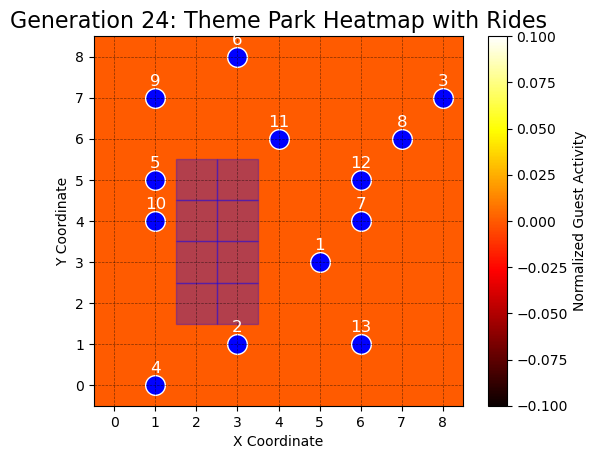

Best ride positions: [(11, (6, 5)), (8, (1, 7)), (3, (1, 0)), (4, (1, 5)), (10, (4, 6)), (0, (5, 3)), (1, (3, 1)), (2, (8, 7)), (12, (6, 1)), (7, (7, 6)), (6, (6, 4)), (9, (1, 4)), (5, (3, 8))]


In [ ]:
# from deap import base, creator, tools, algorithms
# import random
# import numpy as np
# import math
# import matplotlib.pyplot as plt

# # Define the fitness function
# def fitness_function(individual, model, possible_rides):
#     """Calculate the fitness of a ride placement configuration."""
#     # Reset the model for this individual
#     reset_model(model, possible_rides, individual)

#     total_failed_attempts = 0
#     total_rides_per_guest = 0
#     grid_density = np.zeros((model.grid.width, model.grid.height))
#     restricted_penalty = 0  # Penalty for rides in restricted areas
#     popular_ride_penalty = 0  # Penalty for popular rides placed too close
#     total_guests = 0
#     # Extract ride positions and selected rides from the individual
#     ride_positions = [pos for _, pos in individual]
#     selected_rides = [possible_rides[ride_idx] for ride_idx, _ in individual]

#     # Check if any ride is in a restricted area
#     for pos in ride_positions:
#         if model.is_restricted(*pos):  # Check if position is restricted
#             restricted_penalty -= 1000  # Apply a large penalty

#     # Calculate distance between popular rides
#     popular_ride_positions = []
#     for i, pos in enumerate(ride_positions):
#         ride = selected_rides[i]
#         if ride['popularity_rank'] <= len(ride)/3:  # Define popular rides as those with rank <= 2
#             popular_ride_positions.append(pos)

#     # Calculate pairwise distances between popular rides
#     for i in range(len(popular_ride_positions)):
#         for j in range(i + 1, len(popular_ride_positions)):
#             x1, y1 = popular_ride_positions[i]
#             x2, y2 = popular_ride_positions[j]
#             distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)  # Euclidean distance
#             if distance < 5:  # Threshold for spacing (adjust as needed)
#                 popular_ride_penalty -= (5 - distance) * 100  # Penalize based on closeness
    
#     # Add a fixed number of guests for this evaluation
#     num_guests = 1000
#     for i in range(num_guests):
#         guest = GuestAgent(i, model)
#         model.schedule.add(guest)
#         model.grid.place_agent(guest, model.start_pos)

#     # Initialize variables for fitness calculation

#     # Simulate guest behavior for this ride configuration
#     for step in range(26):  # Simulate 26 steps by right 50
#         model.step()  # Advance the entire simulation by one step

#         # Track guest positions at the 25th step
#         if step == 25:
#             for guest in model.schedule.agents:
#                 if isinstance(guest, GuestAgent):
#                     x, y = guest.pos
#                     if 0 <= x < model.grid.width and 0 <= y < model.grid.height:
#                         grid_density[x][y] += 1

#     # Track failed ride attempts and rides completed
#     for guest in model.schedule.agents:
#         if isinstance(guest, GuestAgent):
#             total_failed_attempts += guest.failed_attempts
#             total_rides_per_guest += guest.rides_completed
#             total_guests += 1

#     # Calculate density score (average density at the 25th step)
#     density_score = np.sum(grid_density) / (model.grid.width * model.grid.height)

#     # Combine objectives into a single fitness score
#     satisfaction_score = -total_failed_attempts  # Minimize failed attempts
#     rides_score = total_rides_per_guest  # Maximize rides per guest
#     fitness = satisfaction_score + rides_score - density_score * 2 + restricted_penalty + popular_ride_penalty

#     # Debug: Print intermediate results
#     print(f"Failed attempts: {total_failed_attempts}, Rides per guest: {total_rides_per_guest}, total_guests: {total_guests}")
#     print(f"Density score: {density_score}, Popularity Penalty: {popular_ride_penalty}, restricted_penalty: {restricted_penalty}")
#     print(f"Fitness: {fitness}")

#     # Remove guests after evaluation
#     for guest in list(model.schedule.agents):
#         if isinstance(guest, GuestAgent):
#             model.schedule.remove(guest)
#             model.grid.remove_agent(guest)

#     return (fitness,)

# # Function to generate a valid position (not in restricted area and not occupied by another ride)
# def generate_valid_position(model):
#     while True:
#         pos = (random.randint(0, model.grid.width - 1), random.randint(0, model.grid.height - 1))
#         if not model.is_restricted(*pos):  # Ensure position is not restricted
#             return pos

# # Function to ensure uniqueness of ride indices in an individual
# def ensure_unique_rides(individual, possible_rides):
#     """Ensure that an individual has no duplicate ride indices."""
#     ride_indices = [ride_idx for ride_idx, _ in individual]
#     unique_ride_indices = list(set(ride_indices))  # Remove duplicates
#     if len(unique_ride_indices) < len(ride_indices):
#         # If duplicates exist, replace them with unique ride indices
#         available_rides = set(range(len(possible_rides))) - set(unique_ride_indices)
#         for i in range(len(ride_indices)):
#             if ride_indices[i] in unique_ride_indices:
#                 unique_ride_indices.remove(ride_indices[i])
#             else:
#                 # Replace duplicate with a unique ride index
#                 ride_indices[i] = available_rides.pop()
#         # Update the individual with unique ride indices
#         individual = [(ride_indices[i], pos) for i, (_, pos) in enumerate(individual)]
#     return individual

# # Function to ensure uniqueness of positions in an individual
# def ensure_unique_positions(individual, model):
#     """Ensure that an individual has no duplicate positions."""
#     positions = [pos for _, pos in individual]
#     unique_positions = list(set(positions))  # Remove duplicates
#     if len(unique_positions) < len(positions):
#         # If duplicates exist, replace them with unique positions
#         for i in range(len(positions)):
#             if positions[i] in unique_positions:
#                 unique_positions.remove(positions[i])
#             else:
#                 # Replace duplicate with a unique position
#                 positions[i] = generate_valid_position(model)
#         # Update the individual with unique positions
#         individual = [(ride_idx, positions[i]) for i, (ride_idx, _) in enumerate(individual)]
#     return individual

# # Function to repair the best individual
# def repair_individual(individual, possible_rides, model):
#     """Repair an individual by replacing duplicate ride indices and positions with unique ones."""
#     individual = ensure_unique_rides(individual, possible_rides)
#     individual = ensure_unique_positions(individual, model)
#     return individual

# # Function to reset the model for each individual
# def reset_model(model, possible_rides, individual):
#     """Reset the model and add rides based on the current individual."""
#     # Clear existing rides
#     for agent in list(model.schedule.agents):
#         if isinstance(agent, RideAgent):
#             model.schedule.remove(agent)
#             model.grid.remove_agent(agent)

#     # Add rides from the current individual
#     for ride_idx, pos in individual:
#         ride = possible_rides[ride_idx]
#         model.add_ride(
#             name=ride['name'],
#             pos=pos,
#             capacity=ride['capacity'],
#             service_time=ride['service_time'],
#             popularity_rank=ride['popularity_rank']
#         )

# # Function to plot the current best solution
# def plot_best_solution(best_individual, model, possible_rides, generation):
#     """Plot the current best ride placements."""
#     # Clear the previous plot
#     plt.clf()

#     # Create a grid to count guest positions for the heatmap
#     heatmap = np.zeros((model.grid.width, model.grid.height))

#     # Count guest positions
#     for agent in model.schedule.agents:
#         if isinstance(agent, GuestAgent):
#             x, y = agent.pos
#             heatmap[x][y] += 1

#     # Normalize the heatmap
#     if np.max(heatmap) > 0:
#         heatmap = heatmap / np.max(heatmap)

#     # Plot the heatmap
#     plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')  # Transpose heatmap for correct orientation
#     plt.colorbar(label="Normalized Guest Activity")

#     # Plot each ride and annotate its name
#     for ride_idx, pos in best_individual:
#         ride = possible_rides[ride_idx]
#         x, y = pos
#         plt.scatter(x, y, color='blue', s=200, edgecolor='white', label='Ride')  # Plot ride position
#         plt.text(x, y + 0.3, ride['name'], fontsize=12, ha='center', color='white')  # Add ride name

#     # Plot restricted area
#     for (x, y) in model.restricted_area:
#         plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], [y-0.5, y-0.5, y+0.5, y+0.5], color='blue', alpha=0.3)

#     # Add grid lines and labels
#     plt.xticks(range(model.grid.width))
#     plt.yticks(range(model.grid.height))
#     plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
#     plt.title(f"Generation {generation}: Theme Park Heatmap with Rides", fontsize=16)
#     plt.xlabel("X Coordinate")
#     plt.ylabel("Y Coordinate")
#     plt.show()

# # Function to set up and run the Genetic Algorithm
# def optimize_ride_placement(model, possible_rides, num_rides):
#     # Set up DEAP for Genetic Algorithm
#     creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#     creator.create("Individual", list, fitness=creator.FitnessMax)

#     toolbox = base.Toolbox()
#     # Define an attribute for a ride-position pair
#     toolbox.register("attr_ride_pos", lambda: (random.randint(0, len(possible_rides) - 1), generate_valid_position(model)))
#     toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_ride_pos, n=num_rides)
#     toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#     def evaluate(individual):
#         return fitness_function(individual, model, possible_rides)

#     # Define custom mutation function to handle tuples and avoid restricted areas
#     def mutate_individual(individual, indpb, model):
#         for i in range(len(individual)):
#             if random.random() < indpb:
#                 # Mutate the ride index or position
#                 if random.random() < 0.5:  # Mutate ride index
#                     individual[i] = (random.randint(0, len(possible_rides) - 1), individual[i][1])
#                 else:  # Mutate position
#                     individual[i] = (individual[i][0], generate_valid_position(model))
#         # Ensure uniqueness of ride indices and positions after mutation
#         individual = ensure_unique_rides(individual, possible_rides)
#         individual = ensure_unique_positions(individual, model)
#         return individual,

#     # Define custom crossover function to ensure unique positions
#     def cxTwoPointUnique(ind1, ind2, model):
#         """Perform a two-point crossover while ensuring unique positions."""
#         # Perform the standard two-point crossover
#         tools.cxTwoPoint(ind1, ind2)
#         # Ensure uniqueness of positions in both individuals
#         ind1[:] = ensure_unique_positions(ind1, model)
#         ind2[:] = ensure_unique_positions(ind2, model)
#         return ind1, ind2

#     toolbox.register("evaluate", evaluate)
#     toolbox.register("mate", cxTwoPointUnique, model=model)
#     toolbox.register("mutate", mutate_individual, indpb=0.1, model=model)
#     toolbox.register("select", tools.selTournament, tournsize=3)

#     # Initialize population
#     population = toolbox.population(n=5)
#     # Ensure uniqueness of ride indices and positions in the initial population
#     for ind in population:
#         ind[:] = ensure_unique_rides(ind, possible_rides)
#         ind[:] = ensure_unique_positions(ind, model)

#     # Run the GA in a loop
#     ngen = 25  # Number of generations
#     for generation in range(ngen):
#         print(f"Generation {generation}")

#         # Select the next generation
#         offspring = toolbox.select(population, len(population))
#         offspring = list(map(toolbox.clone, offspring))

#         # Apply crossover and mutation
#         for child1, child2 in zip(offspring[::2], offspring[1::2]):
#             if random.random() < 0.5:  # Crossover probability
#                 toolbox.mate(child1, child2)
#                 del child1.fitness.values
#                 del child2.fitness.values
#                 child1[:] = ensure_unique_rides(child1, possible_rides)
#                 child1[:] = ensure_unique_positions(child1, model)
#                 child2[:] = ensure_unique_rides(child2, possible_rides)
#                 child2[:] = ensure_unique_positions(child2, model)

#         for mutant in offspring:
#             if random.random() < 0.2:  # Mutation probability
#                 toolbox.mutate(mutant)
#                 del mutant.fitness.values

#         # Evaluate the new individuals
#         invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#         fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
#         for ind, fit in zip(invalid_ind, fitnesses):
#             ind.fitness.values = fit

#         # Replace the population with the new generation
#         population[:] = offspring

#     # Get the best solution
#     best_individual = tools.selBest(population, k=1)[0]
#     # Repair the best individual to ensure no duplicates
#     best_individual = repair_individual(best_individual, possible_rides, model)
#     plot_best_solution(best_individual, model, possible_rides, generation)
#     #print("Best ride positions (after repair):", best_individual)
#     return best_individual
    

# # Initialize the theme park model
# tivoli_park = ThemeParkGridModel(width=9, height=9, num_guests=100)

# # Define possible rides (from DataFrame or other source)
# possible_rides = []

# # Add rides dynamically from the DataFrame
# for _, row in tivoli_attr_ranking.iterrows():
#     # Add the ride with parameters from the DataFrame
#     possible_rides.append({"name": row['Ranking'], "capacity": row['CAPACITY'], "service_time": random.randint(5, 10), "popularity_rank": row['Ranking']})

# # Optimize ride placement
# num_rides = len(tivoli_attr_ranking)  # Number of rides to include in the park
# best_ride_positions = optimize_ride_placement(tivoli_park, possible_rides, num_rides)

# # Add the selected rides to the model
# for ride_idx, pos in best_ride_positions:
#     ride = possible_rides[ride_idx]
#     tivoli_park.add_ride(
#         name=ride['name'],
#         pos=pos,
#         capacity=ride['capacity'],
#         service_time=ride['service_time'],
#         popularity_rank=ride['popularity_rank']
#     )

# # Print the best ride positions
# print("Best ride positions:", best_ride_positions)

In [ ]:
from deap import base, creator, tools, algorithms
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Define the fitness function
def fitness_function(individual, model, possible_rides):
    """Calculate the fitness of a ride placement configuration."""
    # Reset the model for this individual
    reset_model(model, possible_rides, individual)

    total_failed_attempts = 0
    total_rides_per_guest = 0
    grid_density = np.zeros((model.grid.width, model.grid.height))
    restricted_penalty = 0  # Penalty for rides in restricted areas
    popular_ride_penalty = 0  # Penalty for popular rides placed too close
    total_guests = 0
    # Extract ride positions and selected rides from the individual
    ride_positions = [pos for _, pos in individual]
    selected_rides = [possible_rides[ride_idx] for ride_idx, _ in individual]

    # Check if any ride is in a restricted area
    for pos in ride_positions:
        if model.is_restricted(*pos):  # Check if position is restricted
            restricted_penalty -= 1000  # Apply a large penalty

    # Calculate distance between popular rides
    popular_ride_positions = []
    for i, pos in enumerate(ride_positions):
        ride = selected_rides[i]
        if ride['popularity_rank'] <= 3:  # Define popular rides as those with rank <= 2
            popular_ride_positions.append(pos)

    # Calculate pairwise distances between popular rides
    for i in range(len(popular_ride_positions)):
        for j in range(i + 1, len(popular_ride_positions)):
            x1, y1 = popular_ride_positions[i]
            x2, y2 = popular_ride_positions[j]
            distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)  # Euclidean distance
            if distance < 3:  # Threshold for spacing (adjust as needed)
                popular_ride_penalty -= (3 - distance) * 100  # Penalize based on closeness
    
    # Add a fixed number of guests for this evaluation
    num_guests = 100
    for i in range(num_guests):
        guest = GuestAgent(i, model)
        model.schedule.add(guest)
        model.grid.place_agent(guest, model.start_pos)

    # Initialize variables for fitness calculation

    # Simulate guest behavior for this ride configuration
    for step in range(26):  # Simulate 26 steps by right 50
        model.step()  # Advance the entire simulation by one step

        # Track guest positions at the 25th step
        if step == 25:
            for guest in model.schedule.agents:
                if isinstance(guest, GuestAgent):
                    x, y = guest.pos
                    if 0 <= x < model.grid.width and 0 <= y < model.grid.height:
                        grid_density[x][y] += 1

    # Track failed ride attempts and rides completed
    for guest in model.schedule.agents:
        if isinstance(guest, GuestAgent):
            total_failed_attempts += guest.failed_attempts
            total_rides_per_guest += guest.rides_completed
            total_guests += 1

    # Calculate density score (average density at the 25th step)
    density_score = np.sum(grid_density) / (model.grid.width * model.grid.height)

    # Combine objectives into a single fitness score
    satisfaction_score = -total_failed_attempts  # Minimize failed attempts
    rides_score = total_rides_per_guest  # Maximize rides per guest
    fitness = satisfaction_score + rides_score - density_score * 2 + restricted_penalty + popular_ride_penalty

    # Debug: Print intermediate results
    print(f"Failed attempts: {total_failed_attempts}, Rides per guest: {total_rides_per_guest}, total_guests: {total_guests}")
    print(f"Density score: {density_score}, Popularity Penalty: {popular_ride_penalty}, restricted_penalty: {restricted_penalty}")
    print(f"Fitness: {fitness}")

    # Remove guests after evaluation
    for guest in list(model.schedule.agents):
        if isinstance(guest, GuestAgent):
            model.schedule.remove(guest)
            model.grid.remove_agent(guest)

    return (fitness,)

# Function to generate a valid position (not in restricted area and not occupied by another ride)
def generate_valid_position(model):
    while True:
        pos = (random.randint(0, model.grid.width - 1), random.randint(0, model.grid.height - 1))
        if not model.is_restricted(*pos):  # Ensure position is not restricted
            return pos

# Function to ensure uniqueness of ride indices in an individual
def ensure_unique_rides(individual, possible_rides):
    """Ensure that an individual has no duplicate ride indices."""
    ride_indices = [ride_idx for ride_idx, _ in individual]
    unique_ride_indices = list(set(ride_indices))  # Remove duplicates
    if len(unique_ride_indices) < len(ride_indices):
        # If duplicates exist, replace them with unique ride indices
        available_rides = set(range(len(possible_rides))) - set(unique_ride_indices)
        for i in range(len(ride_indices)):
            if ride_indices[i] in unique_ride_indices:
                unique_ride_indices.remove(ride_indices[i])
            else:
                # Replace duplicate with a unique ride index
                ride_indices[i] = available_rides.pop()
        # Update the individual with unique ride indices
        individual = [(ride_indices[i], pos) for i, (_, pos) in enumerate(individual)]
    return individual

# Function to ensure uniqueness of positions in an individual
def ensure_unique_positions(individual, model):
    """Ensure that an individual has no duplicate positions."""
    positions = [pos for _, pos in individual]
    unique_positions = list(set(positions))  # Remove duplicates
    if len(unique_positions) < len(positions):
        # If duplicates exist, replace them with unique positions
        for i in range(len(positions)):
            if positions[i] in unique_positions:
                unique_positions.remove(positions[i])
            else:
                # Replace duplicate with a unique position
                positions[i] = generate_valid_position(model)
        # Update the individual with unique positions
        individual = [(ride_idx, positions[i]) for i, (ride_idx, _) in enumerate(individual)]
    return individual

# Function to repair the best individual
def repair_individual(individual, possible_rides, model):
    """Repair an individual by replacing duplicate ride indices and positions with unique ones."""
    individual = ensure_unique_rides(individual, possible_rides)
    individual = ensure_unique_positions(individual, model)
    return individual

# Function to reset the model for each individual
def reset_model(model, possible_rides, individual):
    """Reset the model and add rides based on the current individual."""
    # Clear existing rides
    for agent in list(model.schedule.agents):
        if isinstance(agent, RideAgent):
            model.schedule.remove(agent)
            model.grid.remove_agent(agent)

    # Add rides from the current individual
    for ride_idx, pos in individual:
        ride = possible_rides[ride_idx]
        model.add_ride(
            name=ride['name'],
            pos=pos,
            capacity=ride['capacity'],
            service_time=ride['service_time'],
            popularity_rank=ride['popularity_rank']
        )

# Function to plot the current best solution
def plot_best_solution(best_individual, model, possible_rides, generation):
    """Plot the current best ride placements."""
    # Clear the previous plot
    plt.clf()

    # Create a grid to count guest positions for the heatmap
    heatmap = np.zeros((model.grid.width, model.grid.height))

    # Count guest positions
    for agent in model.schedule.agents:
        if isinstance(agent, GuestAgent):
            x, y = agent.pos
            heatmap[x][y] += 1

    # Normalize the heatmap
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    # Plot the heatmap
    plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')  # Transpose heatmap for correct orientation
    plt.colorbar(label="Normalized Guest Activity")

    # Plot each ride and annotate its name
    sorted_rides = sorted(best_individual, key=lambda x: possible_rides[x[0]]['popularity_rank'])

# Plot each ride with its popularity rank number
    for i, (ride_idx, pos) in enumerate(sorted_rides):
        x, y = pos
        plt.scatter(x, y, color='blue', s=200, edgecolor='white', label='Ride')
        plt.text(x, y + 0.3, str(i+1), fontsize=12, ha='center', color='white')

    # Plot restricted area
    if model.restricted_area:
        for (x, y) in model.restricted_area:
            plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], [y-0.5, y-0.5, y+0.5, y+0.5], color='blue', alpha=0.3)

    # Add grid lines and labels
    plt.xticks(range(model.grid.width))
    plt.yticks(range(model.grid.height))
    plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.title(f"Generation {generation}: Theme Park Heatmap with Rides", fontsize=16)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

# Function to set up and run the Genetic Algorithm
def optimize_ride_placement(model, possible_rides, num_rides):
    # Set up DEAP for Genetic Algorithm
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    # Define an attribute for a ride-position pair
    toolbox.register("attr_ride_pos", lambda: (random.randint(0, len(possible_rides) - 1), generate_valid_position(model)))
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_ride_pos, n=num_rides)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        return fitness_function(individual, model, possible_rides)

    # Define custom mutation function to handle tuples and avoid restricted areas
    def mutate_individual(individual, indpb, model):
        for i in range(len(individual)):
            if random.random() < indpb:
                # Mutate the ride index or position
                if random.random() < 0.5:  # Mutate ride index
                    individual[i] = (random.randint(0, len(possible_rides) - 1), individual[i][1])
                else:  # Mutate position
                    individual[i] = (individual[i][0], generate_valid_position(model))
        # Ensure uniqueness of ride indices and positions after mutation
        individual = ensure_unique_rides(individual, possible_rides)
        individual = ensure_unique_positions(individual, model)
        return individual,

    # Define custom crossover function to ensure unique positions
    def cxTwoPointUnique(ind1, ind2, model):
        """Perform a two-point crossover while ensuring unique positions."""
        # Perform the standard two-point crossover
        tools.cxTwoPoint(ind1, ind2)
        # Ensure uniqueness of positions in both individuals
        ind1[:] = ensure_unique_positions(ind1, model)
        ind2[:] = ensure_unique_positions(ind2, model)
        return ind1, ind2

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", cxTwoPointUnique, model=model)
    toolbox.register("mutate", mutate_individual, indpb=0.1, model=model)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Initialize population
    population = toolbox.population(n=8)
    # Ensure uniqueness of ride indices and positions in the initial population
    for ind in population:
        ind[:] = ensure_unique_rides(ind, possible_rides)
        ind[:] = ensure_unique_positions(ind, model)

    # Run the GA in a loop
    ngen = 10  # Number of generations
    for generation in range(ngen):
        print(f"Generation {generation}")

        # Select the next generation
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:  # Crossover probability
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
                child1[:] = ensure_unique_rides(child1, possible_rides)
                child1[:] = ensure_unique_positions(child1, model)
                child2[:] = ensure_unique_rides(child2, possible_rides)
                child2[:] = ensure_unique_positions(child2, model)

        for mutant in offspring:
            if random.random() < 0.2:  # Mutation probability
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the new individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the new generation
        population[:] = offspring

    # Get the best solution
    best_individual = tools.selBest(population, k=1)[0]
    # Repair the best individual to ensure no duplicates
    best_individual = repair_individual(best_individual, possible_rides, model)
    plot_best_solution(best_individual, model, possible_rides, generation)
    #print("Best ride positions (after repair):", best_individual)
    return best_individual
    


Running simulations for 3 rides...
  Sample 1/10
Generation 0


C:\Users\User\AppData\Local\Temp\ipykernel_22868\1517698279.py:133: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


Failed attempts: 5217, Rides per guest: 152, total_guests: 2837
Density score: 35.02469135802469, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -5293.628026478739
Failed attempts: 1724, Rides per guest: 115, total_guests: 2766
Density score: 34.148148148148145, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1777.2962962962963
Failed attempts: 3157, Rides per guest: 169, total_guests: 2624
Density score: 32.39506172839506, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -3211.368767219481
Failed attempts: 1512, Rides per guest: 0, total_guests: 2781
Density score: 34.333333333333336, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1580.6666666666667
Failed attempts: 1907, Rides per guest: 49, total_guests: 1743
Density score: 21.51851851851852, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -2059.6156807997277
Failed attempts: 0, Rides per guest: 15, total_guests: 126
Density score: 1.55555555555

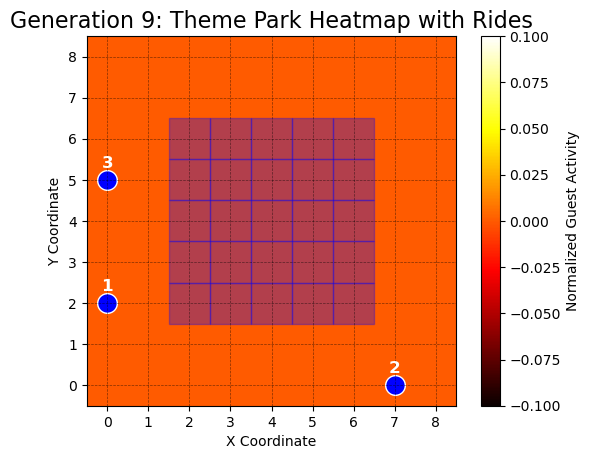

  Sample 2/10
Generation 0
Failed attempts: 5936, Rides per guest: 297, total_guests: 2829
Density score: 34.925925925925924, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -5708.851851851852
Failed attempts: 2131, Rides per guest: 43, total_guests: 2595
Density score: 32.03703703703704, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -2310.652717836764
Failed attempts: 0, Rides per guest: 0, total_guests: 2790
Density score: 34.44444444444444, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -227.46753265157938
Failed attempts: 1548, Rides per guest: 34, total_guests: 2725
Density score: 33.641975308641975, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -1657.677152867305
Failed attempts: 147, Rides per guest: 10, total_guests: 1738
Density score: 21.45679012345679, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -256.3067824969346
Failed attempts: 0, Rides per guest: 7, total_guests: 12

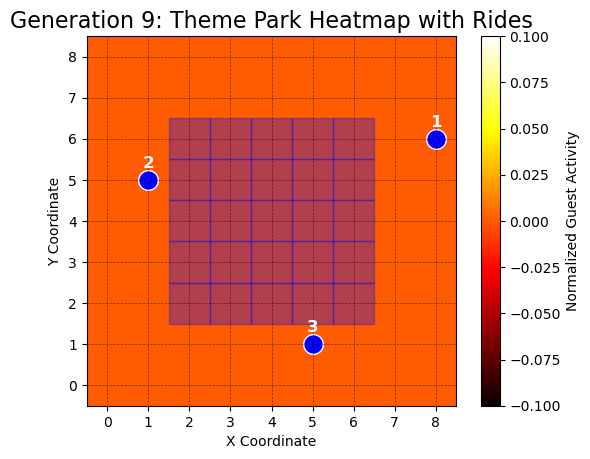

  Sample 3/10
Generation 0
Failed attempts: 3122, Rides per guest: 733, total_guests: 2710
Density score: 33.45679012345679, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2455.9135802469136
Failed attempts: 881, Rides per guest: 603, total_guests: 2229
Density score: 27.51851851851852, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -333.03703703703707
Failed attempts: 1029, Rides per guest: 488, total_guests: 2540
Density score: 31.358024691358025, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -762.2946931454065
Failed attempts: 1713, Rides per guest: 637, total_guests: 2583
Density score: 31.88888888888889, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -1216.1709800277988
Failed attempts: 521, Rides per guest: 424, total_guests: 1553
Density score: 19.17283950617284, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -135.34567901234567
Failed attempts: 0, Rides per guest: 62, total_guests: 126
Density score: 1.55555

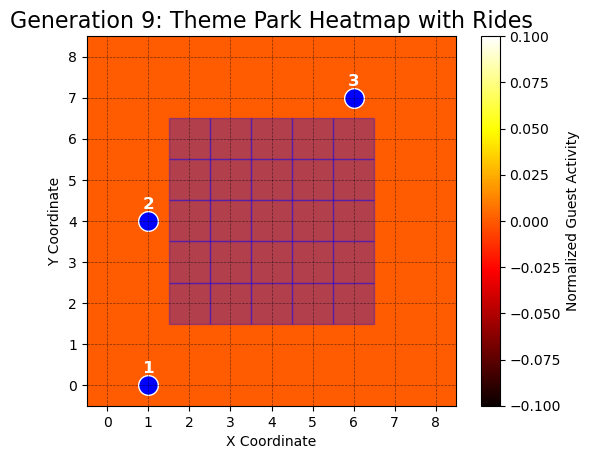

  Sample 4/10
Generation 0
Failed attempts: 1342, Rides per guest: 358, total_guests: 2692
Density score: 33.23456790123457, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1050.469135802469
Failed attempts: 1070, Rides per guest: 361, total_guests: 2692
Density score: 33.23456790123457, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -775.4691358024692
Failed attempts: 1055, Rides per guest: 380, total_guests: 2593
Density score: 32.01234567901235, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -739.0246913580247
Failed attempts: 538, Rides per guest: 191, total_guests: 2905
Density score: 35.864197530864196, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -418.7283950617284
Failed attempts: 1230, Rides per guest: 407, total_guests: 1697
Density score: 20.950617283950617, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -864.9012345679013
Failed attempts: 0, Rides per guest: 0, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, r

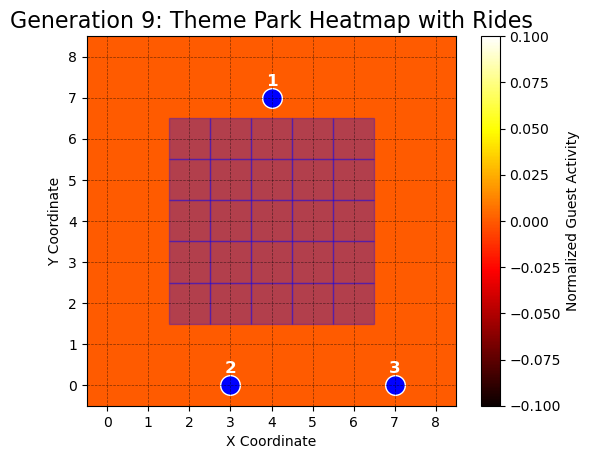

  Sample 5/10
Generation 0
Failed attempts: 2367, Rides per guest: 335, total_guests: 2608
Density score: 32.19753086419753, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2096.395061728395
Failed attempts: 3987, Rides per guest: 448, total_guests: 2523
Density score: 31.14814814814815, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -3759.874940058987
Failed attempts: 3525, Rides per guest: 454, total_guests: 2912
Density score: 35.95061728395062, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -3142.901234567901
Failed attempts: 3743, Rides per guest: 340, total_guests: 2841
Density score: 35.074074074074076, Popularity Penalty: -558.5786437626905, restricted_penalty: 0
Fitness: -4031.726791910839
Failed attempts: 2076, Rides per guest: 345, total_guests: 1863
Density score: 23.0, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1935.5786437626905
Failed attempts: 0, Rides per guest: 27, total_guests: 126
Density score: 1.55

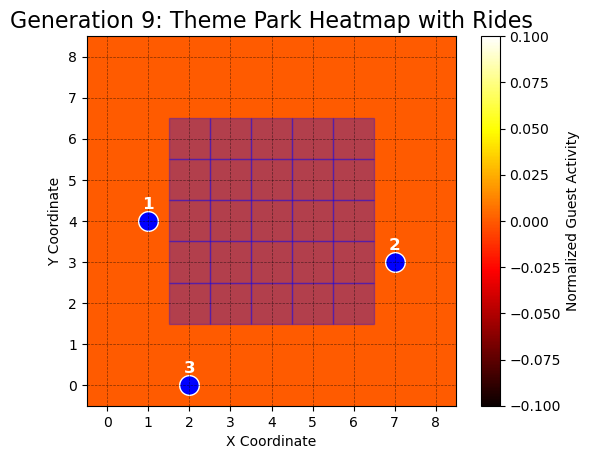

  Sample 6/10
Generation 0
Failed attempts: 1166, Rides per guest: 529, total_guests: 2591
Density score: 31.987654320987655, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -900.9753086419753
Failed attempts: 869, Rides per guest: 345, total_guests: 2707
Density score: 33.41975308641975, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -590.8395061728395
Failed attempts: 1614, Rides per guest: 770, total_guests: 2482
Density score: 30.641975308641975, Popularity Penalty: -17.157287525380973, restricted_penalty: 0
Fitness: -922.4412381426649
Failed attempts: 1728, Rides per guest: 806, total_guests: 2668
Density score: 32.93827160493827, Popularity Penalty: -17.157287525380973, restricted_penalty: 0
Fitness: -1005.0338307352575
Failed attempts: 255, Rides per guest: 291, total_guests: 1618
Density score: 19.97530864197531, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -203.95061728395063
Failed attempts: 0, Rides per guest: 62, total_guests: 126
Density sco

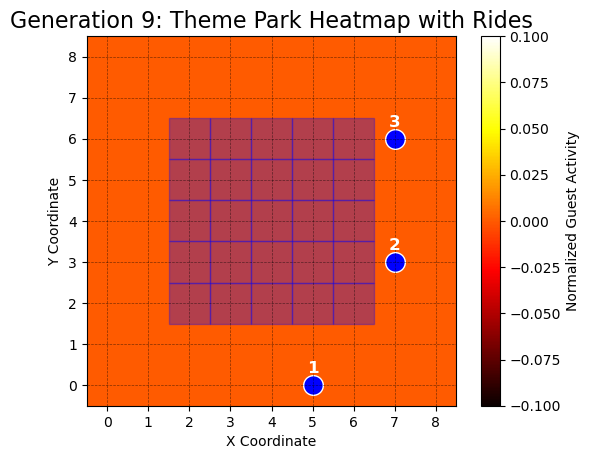

  Sample 7/10
Generation 0
Failed attempts: 336, Rides per guest: 204, total_guests: 2650
Density score: 32.71604938271605, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -197.4320987654321
Failed attempts: 688, Rides per guest: 275, total_guests: 2750
Density score: 33.95061728395062, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -480.90123456790127
Failed attempts: 3170, Rides per guest: 404, total_guests: 2726
Density score: 33.65432098765432, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2833.3086419753085
Failed attempts: 2287, Rides per guest: 156, total_guests: 2884
Density score: 35.60493827160494, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2202.2098765432097
Failed attempts: 815, Rides per guest: 110, total_guests: 1561
Density score: 19.271604938271604, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -743.5432098765432
Failed attempts: 0, Rides per guest: 28, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, 

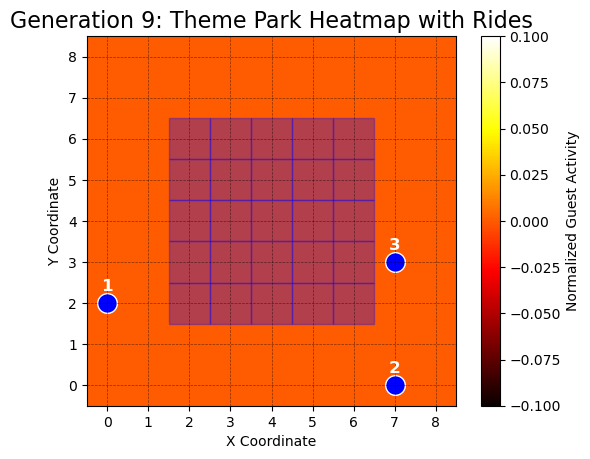

  Sample 8/10
Generation 0
Failed attempts: 4173, Rides per guest: 697, total_guests: 2780
Density score: 34.32098765432099, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -3544.641975308642
Failed attempts: 1017, Rides per guest: 115, total_guests: 2805
Density score: 34.629629629629626, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -971.2592592592592
Failed attempts: 2721, Rides per guest: 397, total_guests: 2696
Density score: 33.28395061728395, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2390.567901234568
Failed attempts: 2280, Rides per guest: 331, total_guests: 2803
Density score: 34.60493827160494, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2018.20987654321
Failed attempts: 1235, Rides per guest: 276, total_guests: 1652
Density score: 20.395061728395063, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -999.7901234567901
Failed attempts: 0, Rides per guest: 0, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, r

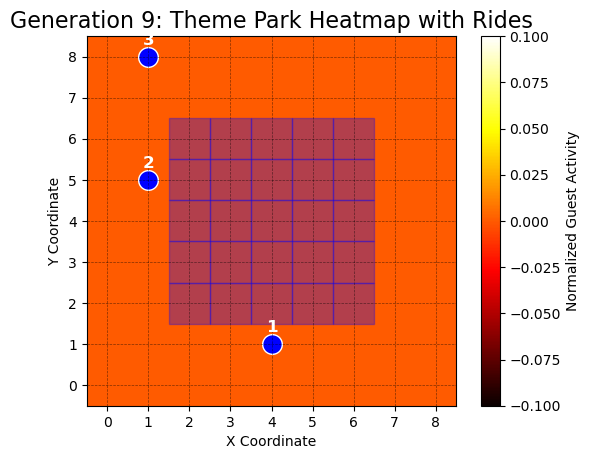

  Sample 9/10
Generation 0
Failed attempts: 3496, Rides per guest: 514, total_guests: 2563
Density score: 31.641975308641975, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -3045.283950617284
Failed attempts: 1355, Rides per guest: 149, total_guests: 2706
Density score: 33.407407407407405, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1272.8148148148148
Failed attempts: 1221, Rides per guest: 105, total_guests: 2451
Density score: 30.25925925925926, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1176.5185185185185
Failed attempts: 2215, Rides per guest: 337, total_guests: 2733
Density score: 33.74074074074074, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1945.4814814814815
Failed attempts: 1573, Rides per guest: 214, total_guests: 1768
Density score: 21.82716049382716, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -1602.6543209876543
Failed attempts: 0, Rides per guest: 46, total_guests: 126
Density score: 1.5555555555555556, Popularity Pe

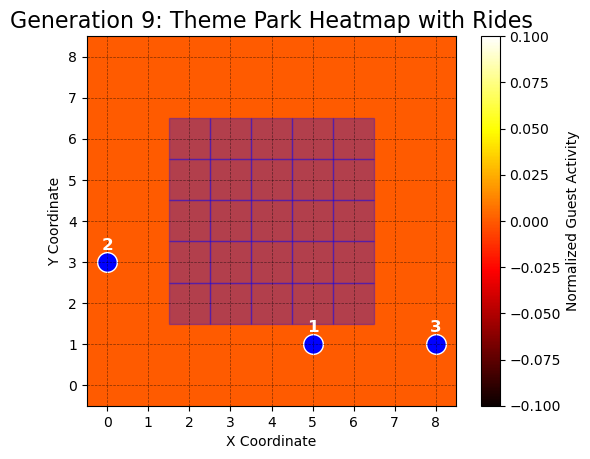

  Sample 10/10
Generation 0
Failed attempts: 131, Rides per guest: 103, total_guests: 2466
Density score: 30.444444444444443, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -288.8888888888889
Failed attempts: 2227, Rides per guest: 548, total_guests: 2706
Density score: 33.407407407407405, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1745.8148148148148
Failed attempts: 1096, Rides per guest: 401, total_guests: 2841
Density score: 35.074074074074076, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -765.1481481481482
Failed attempts: 1535, Rides per guest: 461, total_guests: 2770
Density score: 34.19753086419753, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1142.3950617283951
Failed attempts: 784, Rides per guest: 290, total_guests: 1787
Density score: 22.061728395061728, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -538.1234567901234
Failed attempts: 0, Rides per guest: 35, total_guests: 126
Density score: 1.5555555555555556, Popularity Pen

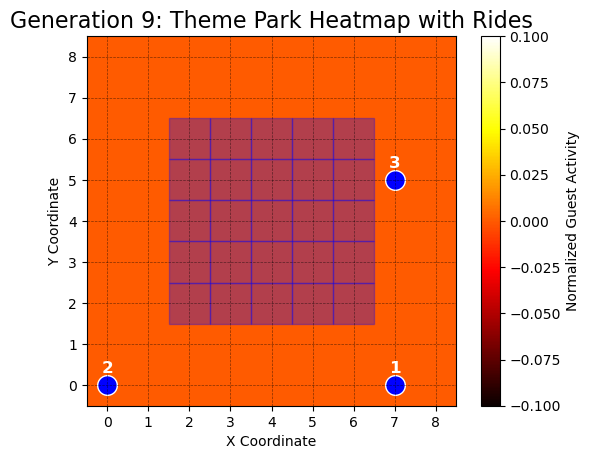


Running simulations for 4 rides...
  Sample 1/10
Generation 0
Failed attempts: 1325, Rides per guest: 171, total_guests: 2699
Density score: 33.32098765432099, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1220.641975308642
Failed attempts: 679, Rides per guest: 229, total_guests: 2493
Density score: 30.77777777777778, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -511.55555555555554
Failed attempts: 1038, Rides per guest: 112, total_guests: 2587
Density score: 31.938271604938272, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1089.8765432098767
Failed attempts: 762, Rides per guest: 145, total_guests: 2767
Density score: 34.160493827160494, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -685.320987654321
Failed attempts: 491, Rides per guest: 133, total_guests: 1755
Density score: 21.666666666666668, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -401.3333333333333
Failed attempts: 0, Rides per guest: 29, total_guests: 126
Density score: 1.

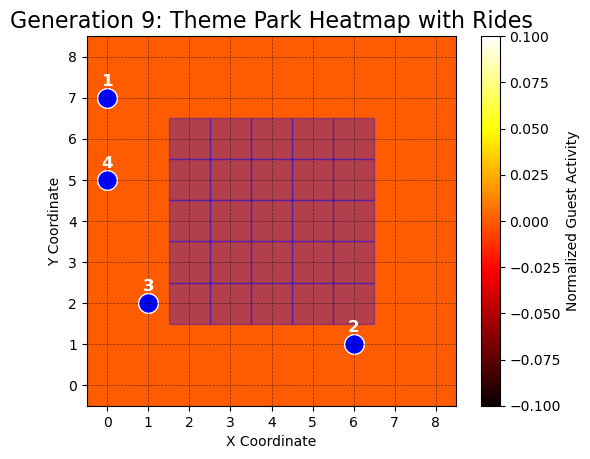

  Sample 2/10
Generation 0
Failed attempts: 2928, Rides per guest: 444, total_guests: 2927
Density score: 36.135802469135804, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -2656.2716049382716
Failed attempts: 1047, Rides per guest: 28, total_guests: 2670
Density score: 32.96296296296296, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1084.9259259259259
Failed attempts: 1548, Rides per guest: 403, total_guests: 2853
Density score: 35.22222222222222, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1215.4444444444443
Failed attempts: 928, Rides per guest: 250, total_guests: 2956
Density score: 36.49382716049383, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -850.9876543209876
Failed attempts: 99, Rides per guest: 67, total_guests: 1517
Density score: 18.728395061728396, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -69.45679012345678
Failed attempts: 0, Rides per guest: 45, total_guests: 126
Density score: 1.5555555555555556, Popularity Pen

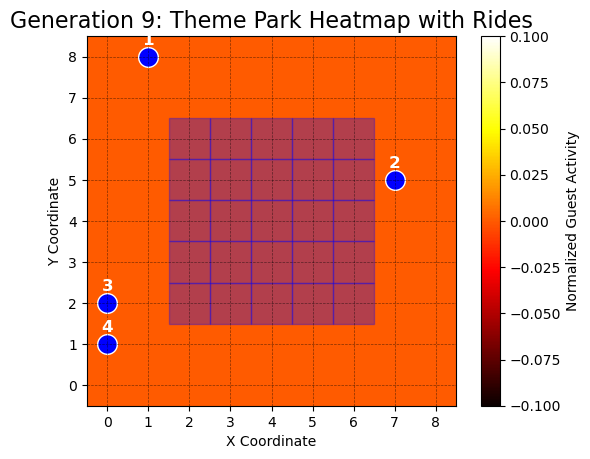

  Sample 3/10
Generation 0
Failed attempts: 1297, Rides per guest: 127, total_guests: 2624
Density score: 32.39506172839506, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1234.79012345679
Failed attempts: 1537, Rides per guest: 241, total_guests: 2666
Density score: 32.91358024691358, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1461.8271604938273
Failed attempts: 1101, Rides per guest: 214, total_guests: 2491
Density score: 30.753086419753085, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1048.5061728395062
Failed attempts: 242, Rides per guest: 179, total_guests: 2602
Density score: 32.123456790123456, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -227.2469135802469
Failed attempts: 465, Rides per guest: 5, total_guests: 1670
Density score: 20.617283950617285, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -577.6277701512556
Failed attempts: 0, Rides per guest: 8, total_guests: 126
Density score: 1.55555555555

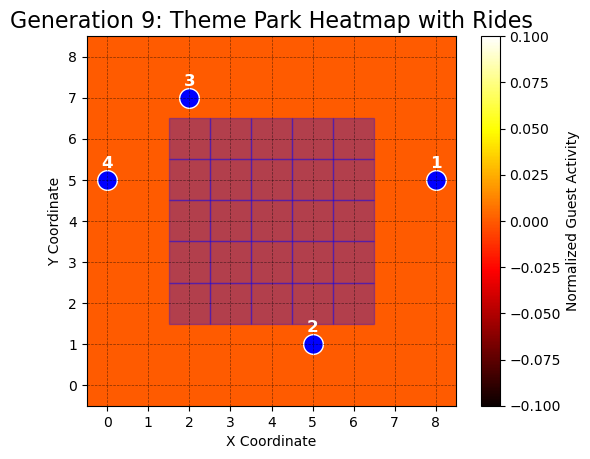

  Sample 4/10
Generation 0
Failed attempts: 2963, Rides per guest: 277, total_guests: 2807
Density score: 34.65432098765432, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -2855.3086419753085
Failed attempts: 2741, Rides per guest: 235, total_guests: 2666
Density score: 32.91358024691358, Popularity Penalty: -152.78640450004204, restricted_penalty: 0
Fitness: -2724.613564993869
Failed attempts: 613, Rides per guest: 33, total_guests: 2826
Density score: 34.888888888888886, Popularity Penalty: -17.157287525380973, restricted_penalty: 0
Fitness: -666.9350653031588
Failed attempts: 1315, Rides per guest: 119, total_guests: 2606
Density score: 32.17283950617284, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1260.3456790123457
Failed attempts: 248, Rides per guest: 111, total_guests: 1669
Density score: 20.604938271604937, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -178.20987654320987
Failed attempts: 0, Rides per guest: 10, total_guests: 126
Density score: 1

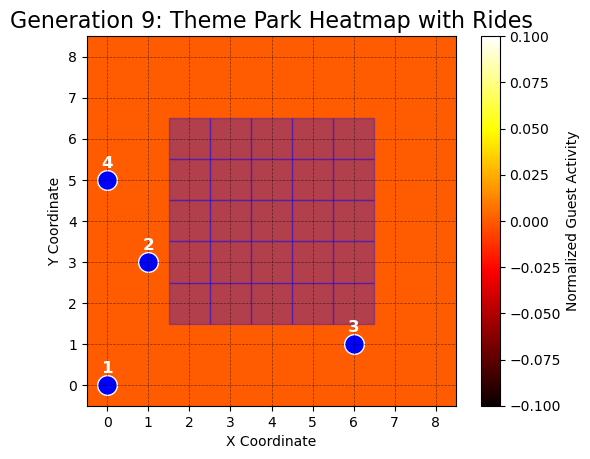

  Sample 5/10
Generation 0
Failed attempts: 1440, Rides per guest: 312, total_guests: 2668
Density score: 32.93827160493827, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1193.8765432098764
Failed attempts: 1982, Rides per guest: 245, total_guests: 2769
Density score: 34.18518518518518, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -2005.3703703703704
Failed attempts: 1216, Rides per guest: 407, total_guests: 2699
Density score: 33.32098765432099, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1034.2206190713325
Failed attempts: 1128, Rides per guest: 63, total_guests: 2840
Density score: 35.06172839506173, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1135.1234567901236
Failed attempts: 727, Rides per guest: 194, total_guests: 1505
Density score: 18.580246913580247, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -570.1604938271605
Failed attempts: 0, Rides per guest: 46, total_guests: 126
Density score: 1.5555555555555556,

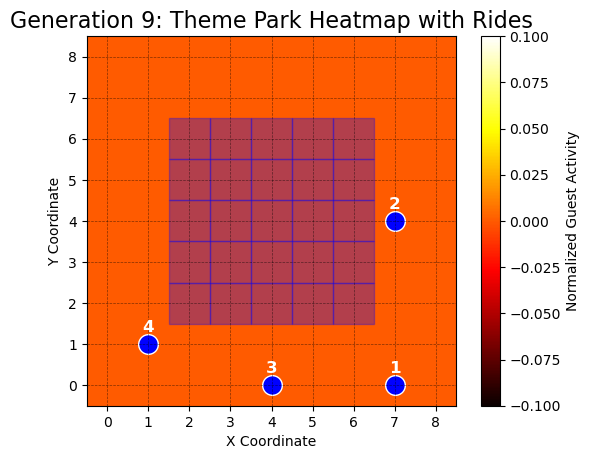

  Sample 6/10
Generation 0
Failed attempts: 3286, Rides per guest: 458, total_guests: 2778
Density score: 34.2962962962963, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2896.5925925925926
Failed attempts: 1390, Rides per guest: 193, total_guests: 2816
Density score: 34.76543209876543, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1266.530864197531
Failed attempts: 859, Rides per guest: 3, total_guests: 2777
Density score: 34.28395061728395, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -924.5679012345679
Failed attempts: 1525, Rides per guest: 249, total_guests: 2570
Density score: 31.728395061728396, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1339.4567901234568
Failed attempts: 129, Rides per guest: 10, total_guests: 1676
Density score: 20.691358024691358, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -160.3827160493827
Failed attempts: 0, Rides per guest: 0, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, rest

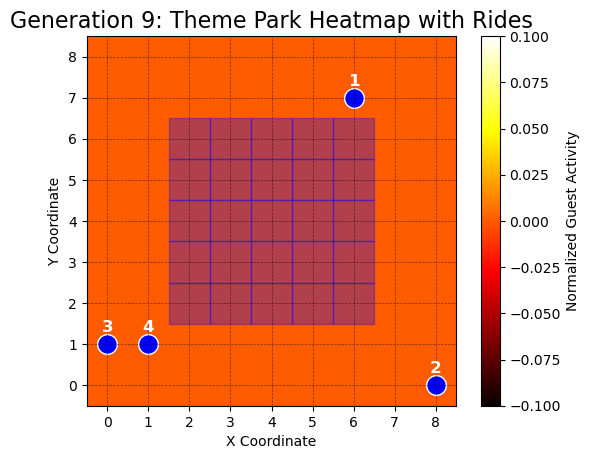

  Sample 7/10
Generation 0
Failed attempts: 2677, Rides per guest: 420, total_guests: 2782
Density score: 34.34567901234568, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -2425.6913580246915
Failed attempts: 1814, Rides per guest: 159, total_guests: 2605
Density score: 32.160493827160494, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1719.320987654321
Failed attempts: 1081, Rides per guest: 156, total_guests: 2517
Density score: 31.074074074074073, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1145.7267919108385
Failed attempts: 1887, Rides per guest: 230, total_guests: 2577
Density score: 31.814814814814813, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1820.6296296296296
Failed attempts: 1086, Rides per guest: 163, total_guests: 1830
Density score: 22.59259259259259, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -968.1851851851852
Failed attempts: 0, Rides per guest: 24, total_guests: 126
Density score: 1.555555555

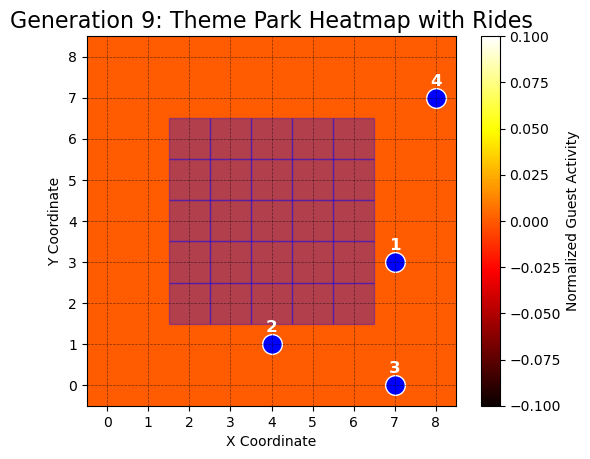

  Sample 8/10
Generation 0
Failed attempts: 1268, Rides per guest: 92, total_guests: 2659
Density score: 32.82716049382716, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1400.2329647503448
Failed attempts: 761, Rides per guest: 140, total_guests: 2713
Density score: 33.49382716049383, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -687.9876543209876
Failed attempts: 468, Rides per guest: 121, total_guests: 2573
Density score: 31.765432098765434, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -410.5308641975309
Failed attempts: 375, Rides per guest: 104, total_guests: 2596
Density score: 32.04938271604938, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -335.09876543209873
Failed attempts: 1453, Rides per guest: 39, total_guests: 1661
Density score: 20.506172839506174, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1555.0123456790122
Failed attempts: 0, Rides per guest: 11, total_guests: 126
Density score: 1.5555555555555556, Po

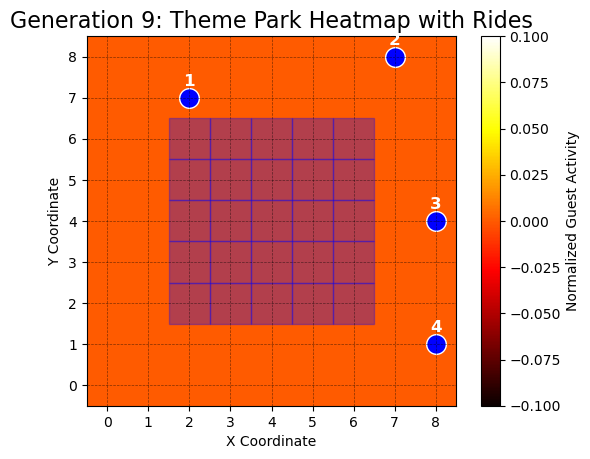

  Sample 9/10
Generation 0
Failed attempts: 1049, Rides per guest: 189, total_guests: 2622
Density score: 32.370370370370374, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -924.7407407407408
Failed attempts: 1299, Rides per guest: 223, total_guests: 3040
Density score: 37.53086419753087, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1151.0617283950617
Failed attempts: 1067, Rides per guest: 480, total_guests: 2704
Density score: 33.382716049382715, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -730.1586343487864
Failed attempts: 1372, Rides per guest: 401, total_guests: 2670
Density score: 32.96296296296296, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -1236.9259259259259
Failed attempts: 759, Rides per guest: 119, total_guests: 1561
Density score: 19.271604938271604, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -678.5432098765432
Failed attempts: 0, Rides per guest: 45, total_guests: 126
Density score: 1.5555555555555556

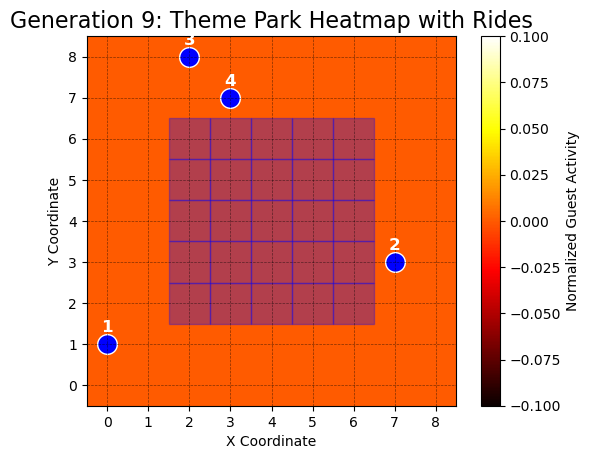

  Sample 10/10
Generation 0
Failed attempts: 1359, Rides per guest: 110, total_guests: 2576
Density score: 31.80246913580247, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1312.6049382716049
Failed attempts: 1607, Rides per guest: 72, total_guests: 2650
Density score: 32.71604938271605, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1600.432098765432
Failed attempts: 1805, Rides per guest: 216, total_guests: 2630
Density score: 32.46913580246913, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -1853.9382716049383
Failed attempts: 1627, Rides per guest: 169, total_guests: 2795
Density score: 34.50617283950617, Popularity Penalty: -17.157287525380973, restricted_penalty: 0
Fitness: -1544.1696332043932
Failed attempts: 344, Rides per guest: 4, total_guests: 1590
Density score: 19.62962962962963, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -479.25925925925924
Failed attempts: 0, Rides per guest: 43, total_guests: 126
Density score: 1.5555555555555

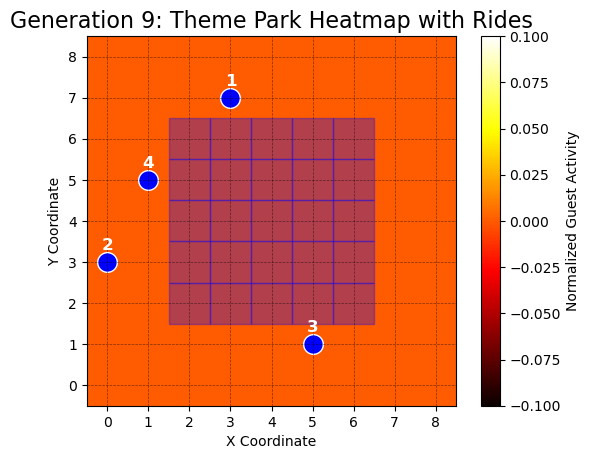


Running simulations for 5 rides...
  Sample 1/10
Generation 0
Failed attempts: 1632, Rides per guest: 263, total_guests: 2769
Density score: 34.18518518518518, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1595.949014133061
Failed attempts: 1394, Rides per guest: 238, total_guests: 2975
Density score: 36.72839506172839, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1388.0354338861473
Failed attempts: 2079, Rides per guest: 334, total_guests: 2614
Density score: 32.27160493827161, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -2009.5432098765432
Failed attempts: 1857, Rides per guest: 290, total_guests: 2719
Density score: 33.5679012345679, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -1834.1358024691358
Failed attempts: 1097, Rides per guest: 222, total_guests: 1814
Density score: 22.395061728395063, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -996.183325706811
Failed attempts: 0,

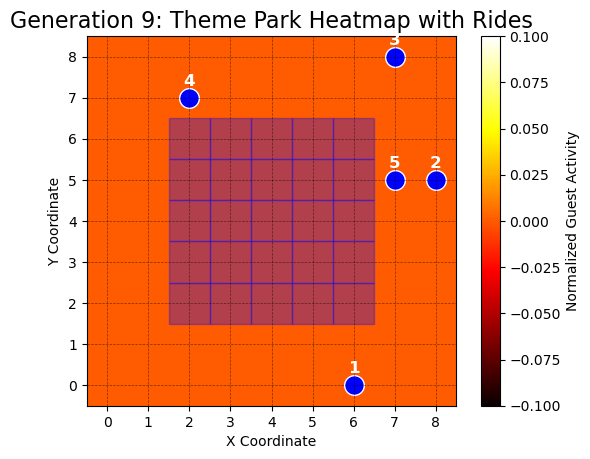

  Sample 2/10
Generation 0
Failed attempts: 1484, Rides per guest: 437, total_guests: 2755
Density score: 34.01234567901235, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1215.0246913580247
Failed attempts: 864, Rides per guest: 345, total_guests: 2698
Density score: 33.30864197530864, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -585.6172839506173
Failed attempts: 561, Rides per guest: 244, total_guests: 2617
Density score: 32.30864197530864, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -381.61728395061726
Failed attempts: 409, Rides per guest: 120, total_guests: 2751
Density score: 33.96296296296296, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -356.9259259259259
Failed attempts: 609, Rides per guest: 115, total_guests: 1934
Density score: 23.876543209876544, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -641.7530864197531
Failed attempts: 0, Rides per guest: 36, total_guests: 126
Density score: 1.5555555555555556, Popularity Pena

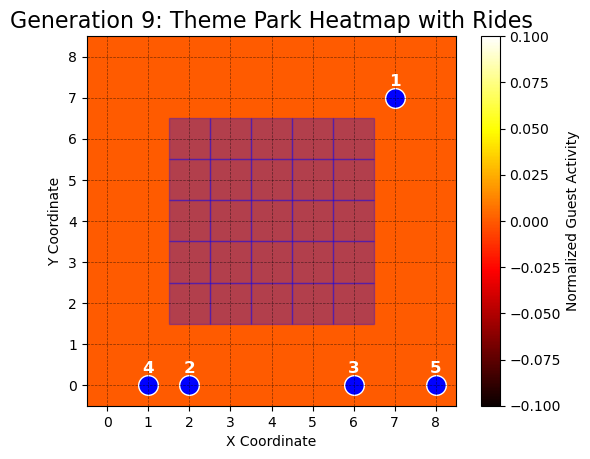

  Sample 3/10
Generation 0
Failed attempts: 1734, Rides per guest: 537, total_guests: 2623
Density score: 32.382716049382715, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1261.7654320987654
Failed attempts: 467, Rides per guest: 184, total_guests: 2773
Density score: 34.23456790123457, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -351.46913580246917
Failed attempts: 944, Rides per guest: 278, total_guests: 2620
Density score: 32.34567901234568, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -889.2700017873818
Failed attempts: 221, Rides per guest: 69, total_guests: 2671
Density score: 32.97530864197531, Popularity Penalty: -558.5786437626905, restricted_penalty: 0
Fitness: -776.5292610466411
Failed attempts: 435, Rides per guest: 152, total_guests: 1653
Density score: 20.40740740740741, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -523.8148148148148
Failed attempts: 0, Rides per guest: 54, total_guests: 126
Density score: 1.55555

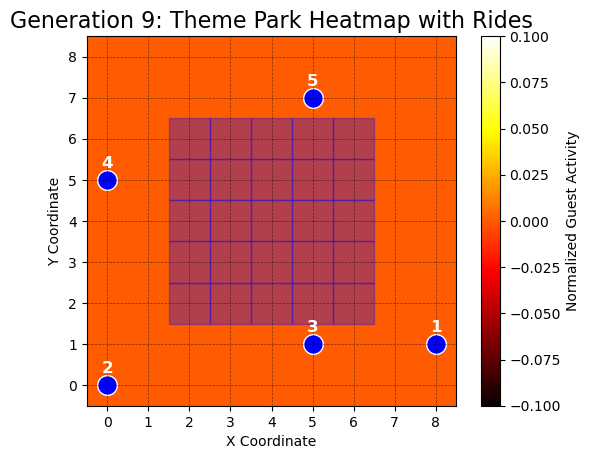

  Sample 4/10
Generation 0
Failed attempts: 93, Rides per guest: 120, total_guests: 2600
Density score: 32.098765432098766, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -37.19753086419753
Failed attempts: 1097, Rides per guest: 44, total_guests: 2436
Density score: 30.074074074074073, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -1313.148148148148
Failed attempts: 1465, Rides per guest: 122, total_guests: 2761
Density score: 34.08641975308642, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1569.7514832688632
Failed attempts: 0, Rides per guest: 73, total_guests: 2670
Density score: 32.96296296296296, Popularity Penalty: 0, restricted_penalty: 0
Fitness: 7.074074074074076
Failed attempts: 694, Rides per guest: 45, total_guests: 1898
Density score: 23.432098765432098, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -895.8641975308642
Failed attempts: 0, Rides per guest: 20, total_guests: 126
Density score: 1.5555555555555556, Pop

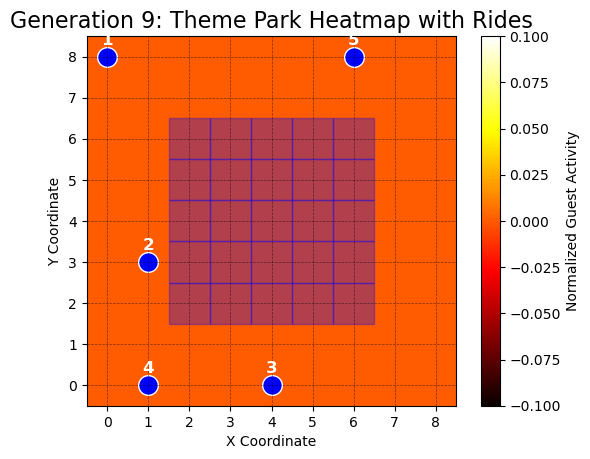

  Sample 5/10
Generation 0
Failed attempts: 1484, Rides per guest: 174, total_guests: 2523
Density score: 31.14814814814815, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1372.2962962962963
Failed attempts: 1263, Rides per guest: 55, total_guests: 2549
Density score: 31.469135802469136, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1370.9382716049383
Failed attempts: 1634, Rides per guest: 78, total_guests: 2783
Density score: 34.358024691358025, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -1724.716049382716
Failed attempts: 380, Rides per guest: 0, total_guests: 2548
Density score: 31.45679012345679, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -642.9135802469136
Failed attempts: 953, Rides per guest: 67, total_guests: 1789
Density score: 22.08641975308642, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -930.1728395061729
Failed attempts: 0, Rides per guest: 7, total_guests: 126
Density score: 1.5555555555555556, Popularity Pe

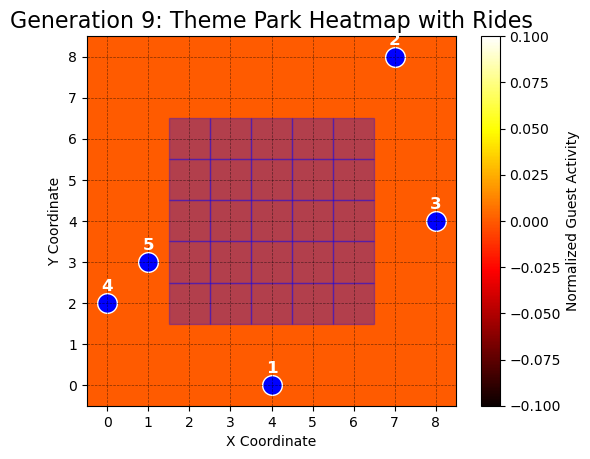

  Sample 6/10
Generation 0
Failed attempts: 3331, Rides per guest: 268, total_guests: 2749
Density score: 33.93827160493827, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -3330.8765432098767
Failed attempts: 2419, Rides per guest: 204, total_guests: 2803
Density score: 34.60493827160494, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -2484.2098765432097
Failed attempts: 256, Rides per guest: 139, total_guests: 2799
Density score: 34.55555555555556, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -386.1111111111111
Failed attempts: 1427, Rides per guest: 176, total_guests: 2729
Density score: 33.69135802469136, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1476.9613598120732
Failed attempts: 126, Rides per guest: 51, total_guests: 1744
Density score: 21.530864197530864, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -318.0617283950617
Failed attempts: 0, Rides per guest: 7, total_guests: 126
Density score: 1.55555

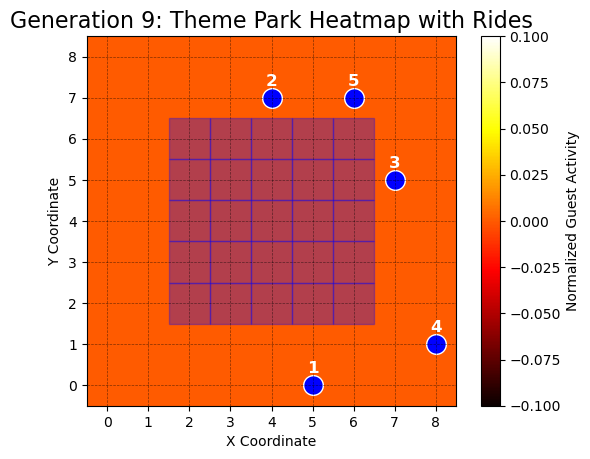

  Sample 7/10
Generation 0
Failed attempts: 1635, Rides per guest: 213, total_guests: 2788
Density score: 34.41975308641975, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1490.8395061728395
Failed attempts: 753, Rides per guest: 128, total_guests: 2561
Density score: 31.617283950617285, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -688.2345679012345
Failed attempts: 312, Rides per guest: 0, total_guests: 2822
Density score: 34.839506172839506, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -581.679012345679
Failed attempts: 830, Rides per guest: 141, total_guests: 2794
Density score: 34.49382716049383, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -757.9876543209876
Failed attempts: 732, Rides per guest: 107, total_guests: 1515
Density score: 18.703703703703702, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -862.4074074074074
Failed attempts: 0, Rides per guest: 0, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty

KeyboardInterrupt: 

In [ ]:
import os
from pathlib import Path
import pandas as pd
import random

# Set up base directory
downloads_path = str(Path.home() / "Downloads")
simulations_dir = os.path.join(downloads_path, 'simulations')

# Create simulations directory if it doesn't exist
os.makedirs(simulations_dir, exist_ok=True)


# Modified plot_best_solution that saves the figure
def plot_and_save_solution(best_individual, model, possible_rides, generation, save_path):
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    heatmap = np.zeros((model.grid.width, model.grid.height))
    for agent in model.schedule.agents:
        if isinstance(agent, GuestAgent):
            x, y = agent.pos
            if 0 <= x < model.grid.width and 0 <= y < model.grid.height:
                heatmap[x][y] += 1
    
    # Normalize and plot
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')
    plt.colorbar(label="Guest Density")

    # Plot rides with their ranking numbers
    for ride_idx, pos in best_individual:
        ride = possible_rides[ride_idx]
        x, y = pos
        plt.scatter(x, y, color='blue', s=200, edgecolor='white')
        plt.text(x, y + 0.3, str(ride['popularity_rank']), 
                ha='center', color='white', fontsize=12, weight='bold')

    # Plot restricted areas if they exist
    if hasattr(model, 'restricted_area'):
        for (x, y) in model.restricted_area:
            plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], 
                    [y-0.5, y-0.5, y+0.5, y+0.5], 
                    color='blue', alpha=0.3)

    plt.title(f"Rides: {len(best_individual)} | Sample: {generation}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

# Run simulations for different numbers of rides
for j in range(3, 14):  # From 3 to 13 rides
    # Create directory for this number of rides
    ride_dir = os.path.join(simulations_dir, f'number_rides_{j}')
    os.makedirs(ride_dir, exist_ok=True)
    
    print(f"\nRunning simulations for {j} rides...")
    
    # Run 10 samples for each number of rides
    for i in range(10):
        print(f"  Sample {i+1}/10")
        
        # Create model and prepare rides
        tivoli_park = ThemeParkGridModel(9, 9, (2, 2), (6, 6))
        possible_rides = []
        
        # Take top j rides from the ranking
        top_rides = tivoli_attr_ranking.sort_values('Ranking').head(j)
        
        for _, row in top_rides.iterrows():
            possible_rides.append({
                "name": str(row['Ranking']),
                "capacity": row['CAPACITY'],
                "service_time": random.randint(5, 10),
                "popularity_rank": row['Ranking']
            })

        # Optimize ride placement
        best_ride_positions = optimize_ride_placement(tivoli_park, possible_rides, j)
        
        # Save the visualization
        save_path = os.path.join(ride_dir, f'sample_{i+1}.png')
        plot_and_save_solution(
            best_ride_positions, 
            tivoli_park, 
            possible_rides, 
            i, 
            save_path
        )

print("\nAll simulations completed! Results saved in:", simulations_dir)

In [50]:
import os
from pathlib import Path
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

# Set up base directory structure
downloads_path = str(Path.home() / "Downloads")
simulations_dir = os.path.join(downloads_path, 'simulations')
os.makedirs(simulations_dir, exist_ok=True)

# Define the three different model configurations
MODEL_CONFIGS = {
    'model1': {  # Small park with central restricted area
        'width': 9,
        'height': 9,
        'restricted_bottom_left': (2, 2),
        'restricted_top_right': (6, 6)
    },
    'model2': {  # Medium park with no restricted areas
        'width': 9,
        'height': 9,
        'restricted_bottom_left': None,
        'restricted_top_right': None
    },
    'model3': {  # Large park with multiple restricted zones
        'width': 15,
        'height': 15,
        'restricted_bottom_left': (1,2),
        'restricted_top_right': (3,6)
    }
}

# Load your data

def plot_and_save_solution(best_individual, model, possible_rides, sample_num, save_path):
    plt.figure(figsize=(10, 8))
    
    # Create and normalize heatmap
    heatmap = np.zeros((model.grid.width, model.grid.height))
    for agent in model.schedule.agents:
        if isinstance(agent, GuestAgent):
            x, y = agent.pos
            if 0 <= x < model.grid.width and 0 <= y < model.grid.height:
                heatmap[x][y] += 1
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    
    # Plot heatmap and rides
    plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')
    
    
    for ride_idx, pos in best_individual:
        ride = possible_rides[ride_idx]
        x, y = pos
        plt.scatter(x, y, color='blue', s=200, edgecolor='white')
        plt.text(x, y + 0.3, str(ride['popularity_rank']), 
                ha='center', color='white', fontsize=12)
    
    # Handle different restricted area formats
    if hasattr(model, 'restricted_area'):
        if isinstance(model.restricted_bottom_left, list):  # Multiple zones
            for bl, tr in zip(model.restricted_bottom_left, model.restricted_top_right):
                plt.fill([bl[0]-0.5, tr[0]+0.5, tr[0]+0.5, bl[0]-0.5],
                        [bl[1]-0.5, bl[1]-0.5, tr[1]+0.5, tr[1]+0.5],
                        color='blue', alpha=0.3)
        elif model.restricted_bottom_left:  # Single zone
            bl, tr = model.restricted_bottom_left, model.restricted_top_right
            plt.fill([bl[0]-0.5, tr[0]+0.5, tr[0]+0.5, bl[0]-0.5],
                    [bl[1]-0.5, bl[1]-0.5, tr[1]+0.5, tr[1]+0.5],
                    color='blue', alpha=0.3)
    
    plt.title(f"Model: {model.name}\nRides: {len(best_individual)} | Sample: {sample_num}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

# Run simulations for all models and ride counts
for model_name, config in MODEL_CONFIGS.items():
    model_dir = os.path.join(simulations_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)
    
    print(f"\nRunning simulations for {model_name}...")
    print(f"Configuration: {config}")
    
    for num_rides in range(3, 15):  # From 3 to 14 rides
        rides_dir = os.path.join(model_dir, f'number_rides_{num_rides}')
        os.makedirs(rides_dir, exist_ok=True)
        
        print(f"  Optimizing {num_rides} rides...")
        
        for sample_num in range(10):  # 10 samples per configuration
            # Initialize model with current configuration
            if isinstance(config['restricted_bottom_left'], list):
                # Handle multiple restricted areas
                tivoli_park = ThemeParkGridModel(
                    width=config['width'],
                    height=config['height'],
                    restricted_bottom_left=config['restricted_bottom_left'],
                    restricted_top_right=config['restricted_top_right']
                )
            else:
                # Handle single or no restricted area
                tivoli_park = ThemeParkGridModel(
                    width=config['width'],
                    height=config['height'],
                    restricted_bottom_left=config['restricted_bottom_left'],
                    restricted_top_right=config['restricted_top_right']
                )
            tivoli_park.name = model_name  # Store model name for plotting
            
            # Prepare top N rides
            top_rides = tivoli_attr_ranking.sort_values('Ranking').head(num_rides)
            possible_rides = [{
                "name": str(row['Ranking']),
                "capacity": row['CAPACITY'],
                "service_time": random.randint(5, 10),
                "popularity_rank": row['Ranking']
            } for _, row in top_rides.iterrows()]
            
            # Optimize and save results
            best_ride_positions = optimize_ride_placement(tivoli_park, possible_rides, num_rides)
            save_path = os.path.join(rides_dir, f'sample_{sample_num}.png')
            plot_and_save_solution(best_ride_positions, tivoli_park, possible_rides, sample_num, save_path)

print(f"\nAll simulations completed! Results saved in: {simulations_dir}")


Running simulations for model1...
Configuration: {'width': 9, 'height': 9, 'restricted_bottom_left': (2, 2), 'restricted_top_right': (6, 6)}
  Optimizing 3 rides...
Generation 0


C:\Users\User\AppData\Local\Temp\ipykernel_22868\1517698279.py:133: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


KeyboardInterrupt: 

C:\Users\User\AppData\Local\Temp\ipykernel_22868\1517698279.py:133: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)
c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Sample 0
Generation 0
Failed attempts: 1156, Rides per guest: 22, total_guests: 2585
Density score: 31.91358024691358, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1197.8271604938273
Failed attempts: 2933, Rides per guest: 42, total_guests: 2750
Density score: 33.95061728395062, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2958.901234567901
Failed attempts: 1537, Rides per guest: 15, total_guests: 2693
Density score: 33.24691358024691, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1588.4938271604938
Failed attempts: 1325, Rides per guest: 12, total_guests: 2672
Density score: 32.98765432098765, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1378.9753086419753
Failed attempts: 149, Rides per guest: 2, total_guests: 1745
Density score: 21.54320987654321, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -190.08641975308643
Failed attempts: 0, Rides per guest: 2, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, restricted

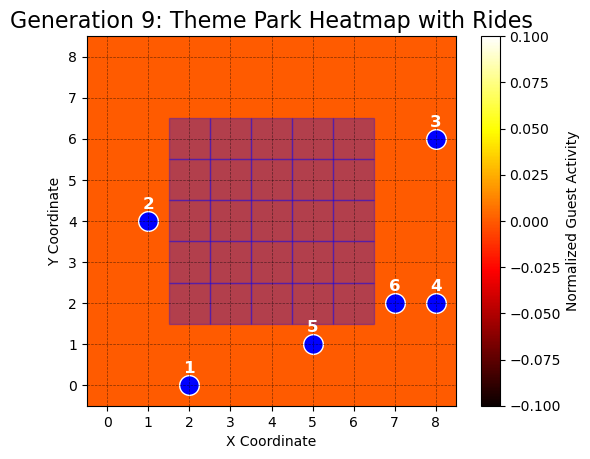

Sample 1
Generation 0
Failed attempts: 1018, Rides per guest: 309, total_guests: 2734
Density score: 33.75308641975309, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -776.5061728395062
Failed attempts: 599, Rides per guest: 186, total_guests: 2593
Density score: 32.01234567901235, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -477.0246913580247
Failed attempts: 1011, Rides per guest: 90, total_guests: 2444
Density score: 30.17283950617284, Popularity Penalty: -558.5786437626905, restricted_penalty: 0
Fitness: -1539.9243227750362
Failed attempts: 477, Rides per guest: 130, total_guests: 2485
Density score: 30.679012345679013, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -408.358024691358
Failed attempts: 709, Rides per guest: 38, total_guests: 1662
Density score: 20.51851851851852, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -912.0370370370371
Failed attempts: 0, Rides per guest: 0, total_guests: 126
Density score: 1.5555555555555556, Popularity P

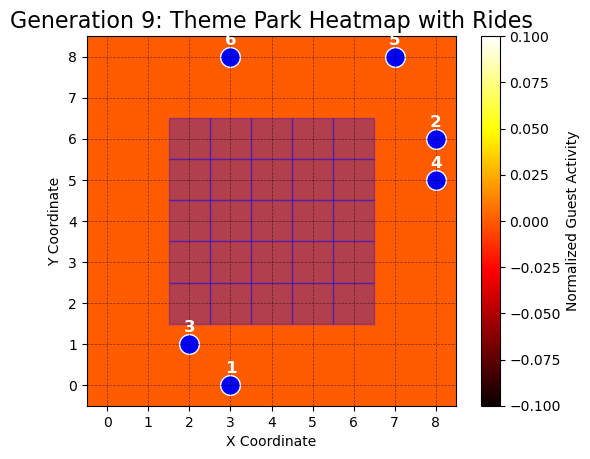

Sample 2
Generation 0
Failed attempts: 1096, Rides per guest: 542, total_guests: 2738
Density score: 33.80246913580247, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -621.604938271605
Failed attempts: 1596, Rides per guest: 500, total_guests: 2969
Density score: 36.65432098765432, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1169.3086419753085
Failed attempts: 1173, Rides per guest: 605, total_guests: 2702
Density score: 33.358024691358025, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -634.716049382716
Failed attempts: 600, Rides per guest: 372, total_guests: 2635
Density score: 32.53086419753087, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -293.0617283950617
Failed attempts: 0, Rides per guest: 27, total_guests: 1727
Density score: 21.320987654320987, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -15.641975308641975
Failed attempts: 0, Rides per guest: 43, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, restricte

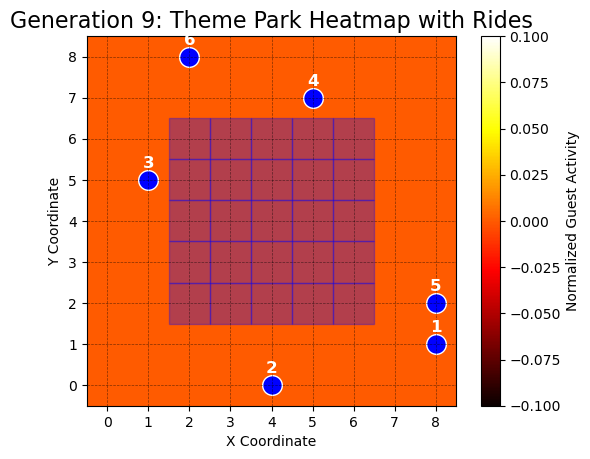

Sample 3
Generation 0
Failed attempts: 528, Rides per guest: 59, total_guests: 2359
Density score: 29.123456790123456, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -527.2469135802469
Failed attempts: 295, Rides per guest: 18, total_guests: 2464
Density score: 30.419753086419753, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -337.8395061728395
Failed attempts: 975, Rides per guest: 725, total_guests: 2462
Density score: 30.395061728395063, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -310.7901234567901
Failed attempts: 600, Rides per guest: 191, total_guests: 2704
Density score: 33.382716049382715, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -675.7654320987654
Failed attempts: 204, Rides per guest: 183, total_guests: 1824
Density score: 22.51851851851852, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -266.03703703703707
Failed attempts: 0, Rides per guest: 28, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -

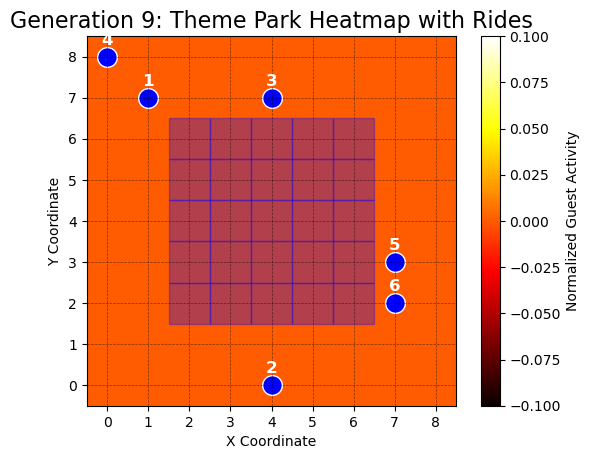

Sample 4
Generation 0
Failed attempts: 646, Rides per guest: 0, total_guests: 2702
Density score: 33.358024691358025, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -712.716049382716
Failed attempts: 421, Rides per guest: 1, total_guests: 2837
Density score: 35.02469135802469, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -690.0493827160494


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001A53710C050>>
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\ipykernel\ipkernel.py", line 796, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\yuan\Lib\threading.py", line 1510, in enumerate
    return list(_active.values()) + list(_limbo.values())
                                         ^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\ipykernel\kernelapp.py", line 600, in sigint_handler
    raise KeyboardInterrupt
KeyboardInterrupt: 


Failed attempts: 119, Rides per guest: 5, total_guests: 2375
Density score: 29.320987654320987, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -172.64197530864197
Failed attempts: 669, Rides per guest: 172, total_guests: 2672
Density score: 32.98765432098765, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -562.9753086419753
Failed attempts: 472, Rides per guest: 134, total_guests: 1838
Density score: 22.691358024691358, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -383.38271604938274
Failed attempts: 0, Rides per guest: 46, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, restricted_penalty: 0
Fitness: 42.888888888888886
Failed attempts: 0, Rides per guest: 21, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, restricted_penalty: 0
Fitness: 17.88888888888889
Failed attempts: 0, Rides per guest: 5, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -98

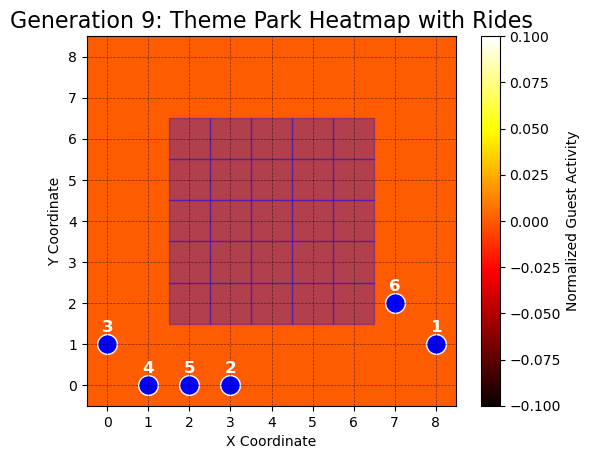

Sample 5
Generation 0
Failed attempts: 2027, Rides per guest: 130, total_guests: 2605
Density score: 32.160493827160494, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1961.320987654321
Failed attempts: 1643, Rides per guest: 200, total_guests: 2852
Density score: 35.20987654320987, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -1671.9983968491103
Failed attempts: 847, Rides per guest: 14, total_guests: 2404
Density score: 29.679012345679013, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -892.358024691358
Failed attempts: 712, Rides per guest: 12, total_guests: 2594
Density score: 32.02469135802469, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -764.0493827160494
Failed attempts: 843, Rides per guest: 38, total_guests: 1565
Density score: 19.320987654320987, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -843.641975308642
Failed attempts: 0, Rides per guest: 3, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalt

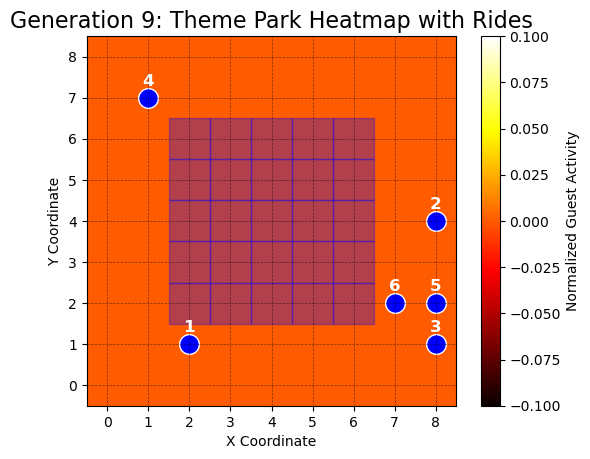

Sample 6
Generation 0
Failed attempts: 1905, Rides per guest: 428, total_guests: 2765
Density score: 34.135802469135804, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1545.2716049382716
Failed attempts: 1693, Rides per guest: 133, total_guests: 2490
Density score: 30.74074074074074, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -1821.4814814814815
Failed attempts: 1644, Rides per guest: 152, total_guests: 2938
Density score: 36.27160493827161, Popularity Penalty: -400.0, restricted_penalty: 0
Fitness: -1964.5432098765432
Failed attempts: 1476, Rides per guest: 112, total_guests: 2847
Density score: 35.148148148148145, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -1634.2962962962963
Failed attempts: 609, Rides per guest: 85, total_guests: 1659
Density score: 20.48148148148148, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -564.9629629629629
Failed attempts: 0, Rides per guest: 9, total_guests: 126
Density score: 1.5555555555555556, Popularity 

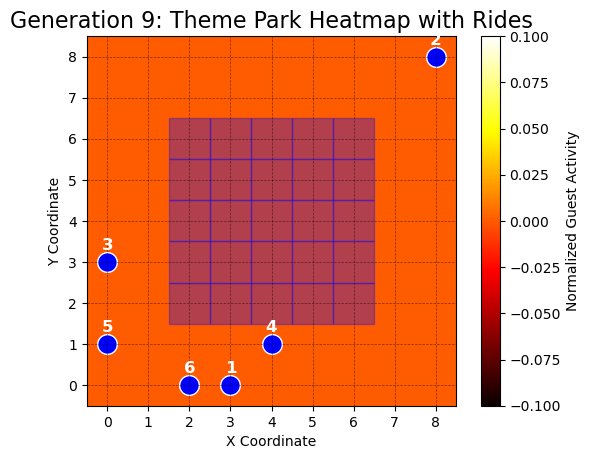

Sample 7
Generation 0
Failed attempts: 1426, Rides per guest: 552, total_guests: 2597
Density score: 32.06172839506173, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -1014.5166590401444
Failed attempts: 879, Rides per guest: 249, total_guests: 2802
Density score: 34.592592592592595, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -775.5783874352062
Failed attempts: 1031, Rides per guest: 66, total_guests: 2728
Density score: 33.67901234567901, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1032.358024691358
Failed attempts: 653, Rides per guest: 10, total_guests: 2759
Density score: 34.06172839506173, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -711.1234567901234
Failed attempts: 688, Rides per guest: 147, total_guests: 1685
Density score: 20.80246913580247, Popularity Penalty: -76.39320225002102, restricted_penalty: 0
Fitness: -658.9981405216259
Failed attempts: 0, Rides per guest: 31, total_guests: 126
Density score: 1

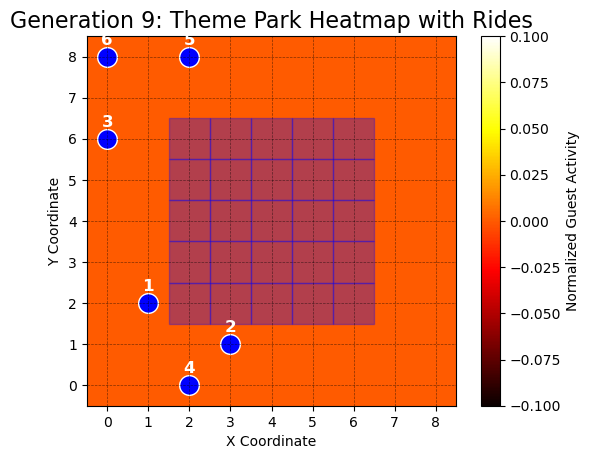

Sample 8
Generation 0
Failed attempts: 1432, Rides per guest: 656, total_guests: 2852
Density score: 35.20987654320987, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -846.4197530864197
Failed attempts: 1327, Rides per guest: 478, total_guests: 2672
Density score: 32.98765432098765, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -914.9753086419753
Failed attempts: 959, Rides per guest: 310, total_guests: 2777
Density score: 34.28395061728395, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -717.5679012345679
Failed attempts: 847, Rides per guest: 343, total_guests: 2950
Density score: 36.41975308641975, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -576.8395061728395
Failed attempts: 665, Rides per guest: 209, total_guests: 1497
Density score: 18.48148148148148, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -492.96296296296293
Failed attempts: 0, Rides per guest: 69, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -76.3932022

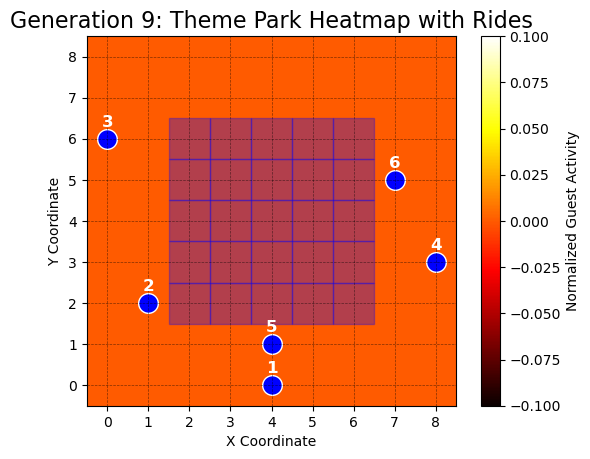

Sample 9
Generation 0
Failed attempts: 842, Rides per guest: 203, total_guests: 2559
Density score: 31.59259259259259, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -702.1851851851852
Failed attempts: 1250, Rides per guest: 122, total_guests: 2642
Density score: 32.617283950617285, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -1393.2345679012346
Failed attempts: 1039, Rides per guest: 324, total_guests: 2596
Density score: 32.04938271604938, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -779.0987654320987
Failed attempts: 971, Rides per guest: 90, total_guests: 2540
Density score: 31.358024691358025, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -943.716049382716
Failed attempts: 184, Rides per guest: 14, total_guests: 1555
Density score: 19.19753086419753, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -208.39506172839506
Failed attempts: 0, Rides per guest: 35, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, res

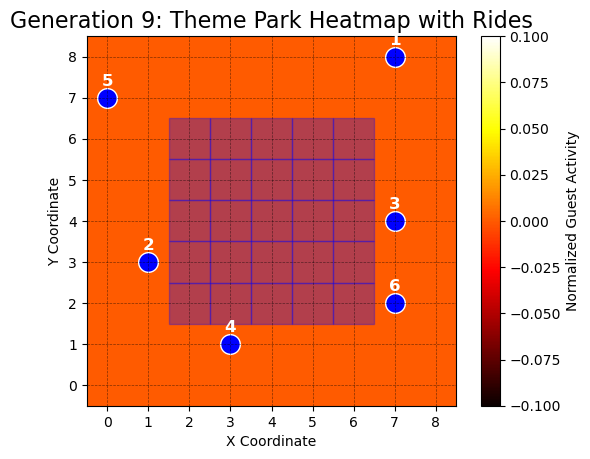

In [ ]:
import os
from pathlib import Path
import pandas as pd
import random

#Trial Simulation
downloads_path = str(Path.home() / "Downloads")
simulations_dir = os.path.join(downloads_path, 'simulations')
# Create simulations directory if it doesn't exist
os.makedirs(simulations_dir, exist_ok=True)

for i in range(10):
    tivoli_park = ThemeParkGridModel(9,9,(2,2),(6,6))

    # Define possible rides (from DataFrame or other source)
    possible_rides = []

    # Add rides dynamically from the DataFrame
    for _, row in tivoli_attr_ranking.iterrows():
        # Add the ride with parameters from the DataFrame
        possible_rides.append({"name": row['Ranking'], "capacity": row['CAPACITY'], "service_time": random.randint(5, 10), "popularity_rank": row['Ranking']})

    # Optimize ride placement
    num_rides = len(tivoli_attr_ranking)  # Number of rides to include in the park
    print(f"Sample {i}")
    best_ride_positions = optimize_ride_placement(tivoli_park, possible_rides, 6)



# # Add the selected rides to the model
# for ride_idx, pos in best_ride_positions:
#     ride = possible_rides[ride_idx]
#     tivoli_park.add_ride(
#         name=ride['name'],
#         pos=pos,
#         capacity=ride['capacity'],
#         service_time=ride['service_time'],
#         popularity_rank=ride['popularity_rank']
#     )

# # Print the best ride positions
# print("Best ride positions:", best_ride_positions)

In [ ]:
print(best_ride_positions)
tivoli_park = ThemeParkGridModel(width=9, height=9)

for i, position in enumerate(best_ride_positions):
    ride_idx = position[0]  # Get the ride index
    pos = position[1]  # Get the position (x, y)
    #print(pos)
    # Get the corresponding row from the DataFrame
    row = tivoli_attr_ranking.iloc[ride_idx]
    while True:        
        # Check if the position is not in the restricted area and not occupied by another ride
        if not tivoli_park.is_restricted(*pos):  # Ensure the position is not in the restricted area
            # Check if the position is not occupied by another ride
            cell_contents = tivoli_park.grid.get_cell_list_contents([pos])
            if not any(isinstance(agent, RideAgent) for agent in cell_contents):
                break  # Valid position found
    #print(f"here {i}")
    tivoli_park.add_ride(
        name=row['Ranking'],  # Use the correct column name
        pos=position[1],
        capacity=row['CAPACITY'],
        service_time=random.randint(5, 10),
        popularity_rank=row['Ranking']
    )

for _ in range(540):  # Run for 50 steps
    tivoli_park.step()
    if _ % 10 == 0:  # Plot every 10 steps
        continue
    print(f'Step: {_}')
    plot_combined_heatmap_and_rides_normalized(tivoli_park)

[(0, (5, 7)), (3, (1, 8)), (9, (0, 7)), (8, (8, 3)), (4, (3, 1)), (5, (0, 1)), (10, (0, 0)), (1, (1, 4)), (12, (2, 7)), (2, (6, 1)), (11, (3, 7)), (6, (0, 2)), (7, (0, 8))]


TypeError: ThemeParkGridModel.__init__() got an unexpected keyword argument 'num_guests'

In [19]:
def start_simulation_run(Model, dataframe, num_rides):
    if num_rides > 13:
        return "The model only supports less than 13 rides please input less than 13"
    if num_rides < 2:
        return "Need a minimum of 2 rides to run the simulation"
    
    # Create a fresh copy of the model to avoid modifying the original
    if Model.restricted_bottom_left:
        Model2 = ThemeParkGridModel(width=Model.grid.width, 
                              height=Model.grid.height,
                              restricted_bottom_left=Model.restricted_bottom_left,
                              restricted_top_right=Model.restricted_top_right)
    else:
        Model2 = ThemeParkGridModel(width=Model.grid.width, 
                              height=Model.grid.height
                              )
        
    # Sort dataframe by Ranking to ensure lower numbers come first
    dataframe = dataframe.sort_values('Ranking').copy()
    possible_rides = []
    
    # Add rides dynamically from the sorted DataFrame
    for _, row in dataframe.iterrows():
        possible_rides.append({
            "name": str(row['Ranking']),
            "capacity": row['CAPACITY'],
            "service_time": random.randint(5, 10),
            "popularity_rank": row['Ranking']
        })

    # Optimize ride placement
    best_ride_positions = optimize_ride_placement(Model2, possible_rides, num_rides)
    
    # Verify selected rides
    selected_rides = [possible_rides[idx]['name'] for idx, _ in best_ride_positions]
    print(f"Selected rides by ranking: {selected_rides}")
    print("Best ride positions:", best_ride_positions)

    # Add the selected rides to the model
    for ride_idx, pos in best_ride_positions:
        row = dataframe.iloc[ride_idx]
        while True:        
            if not Model.is_restricted(*pos):
                cell_contents = Model.grid.get_cell_list_contents([pos])
                if not any(isinstance(agent, RideAgent) for agent in cell_contents):
                    break
            # Generate new position if current is invalid
            pos = generate_valid_position(Model)
        
        Model.add_ride(
            name=str(row['Ranking']),
            pos=pos,
            capacity=row['CAPACITY'],
            service_time=random.randint(5, 10),
            popularity_rank=row['Ranking']
        )

    # Run the simulation
    for step in range(540):
        Model.step()
        if step % 10 == 0:
            print(f'Step: {step}')
            plot_combined_heatmap_and_rides_normalized(Model)
            number = Model.get_total_guests()
            print(f"total guests: {number}")
    
    return Model  # Return the model with the optimized configuration


In [26]:
#hemeParkGridModel(Model):def __init__(self, width, height, restricted_bottom_left=None, restricted_top_right=None, guest_inflow_type = None):
#each step 1 minute, 1km takes about 10mins, 1 sqaure is 50m(strolling) USS is 20ha roughly 100 x 100 is 1 ha 4 squares 1 ha, 80squares 20ha, guests spend on average 6 hours which is 360
ringmodel = ThemeParkGridModel(9,9,(2,2),(6,6))

# Define possible rides (from DataFrame or other source)
possible_rides = []

# Add rides dynamically from the DataFrame
for _, row in tivoli_attr_ranking.iterrows():
    # Add the ride with parameters from the DataFrame
    possible_rides.append({"name": row['Ranking'], "capacity": row['CAPACITY'], "service_time": random.randint(5, 10), "popularity_rank": row['Ranking']})

# Optimize ride placement
num_rides = len(tivoli_attr_ranking)  # Number of rides to include in the park

best_ride_positions = optimize_ride_placement(ringmodel, possible_rides, num_rides)

# Add the selected rides to the model
for ride_idx, pos in best_ride_positions:
    ride = possible_rides[ride_idx]
    ringmodel.add_ride(
        name=ride['name'],
        pos=pos,
        capacity=ride['capacity'],
        service_time=ride['service_time'],
        popularity_rank=ride['popularity_rank']
    )

# Print the best ride positions
print("Best ride positions:", best_ride_positions)

ringmodel = ThemeParkGridModel(9,9,(2,2),(6,6))

for i, position in enumerate(best_ride_positions):
    ride_idx = position[0]  # Get the ride index
    pos = position[1]  # Get the position (x, y)
    #print(pos)
    # Get the corresponding row from the DataFrame
    row = tivoli_attr_ranking.iloc[ride_idx]
    while True:        
        # Check if the position is not in the restricted area and not occupied by another ride
        if not ringmodel.is_restricted(*pos):  # Ensure the position is not in the restricted area
            # Check if the position is not occupied by another ride
            cell_contents = ringmodel.grid.get_cell_list_contents([pos])
            if not any(isinstance(agent, RideAgent) for agent in cell_contents):
                break  # Valid position found
    #print(f"here {i}")
    ringmodel.add_ride(
        name=row['Ranking'],  # Use the correct column name
        pos=position[1],
        capacity=row['CAPACITY'],
        service_time=random.randint(5, 10),
        popularity_rank=row['Ranking']
    )

for _ in range(540):  # Run for 50 steps
    ringmodel.step()
    if _ % 10 == 0:  # Plot every 5 steps
        continue
    print(f'Step: {_}')
    plot_combined_heatmap_and_rides_normalized(ringmodel)


C:\Users\User\AppData\Local\Temp\ipykernel_22868\3082754752.py:133: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


Generation 0
Failed attempts: 327, Rides per guest: 247, total_guests: 1383
Density score: 17.074074074074073, Popularity Penalty: -17.157287525380973, restricted_penalty: 0
Fitness: -131.30543567352913
Failed attempts: 0, Rides per guest: 19, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -100.0, restricted_penalty: 0
Fitness: -84.11111111111111
Failed attempts: 0, Rides per guest: 25, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -17.157287525380973, restricted_penalty: 0
Fitness: 4.731601363507917
Failed attempts: 0, Rides per guest: 30, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -173.11111111111111
Failed attempts: 0, Rides per guest: 16, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -145.6897548738016
Failed attempts: 0, Rides per guest: 13, total_guests: 126
Density score: 1.55555555

KeyboardInterrupt: 

C:\Users\User\AppData\Local\Temp\ipykernel_22868\3082754752.py:133: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


Generation 0
Failed attempts: 53, Rides per guest: 85, total_guests: 1448
Density score: 17.876543209876544, Popularity Penalty: -200.0, restricted_penalty: 0
Fitness: -203.7530864197531
Failed attempts: 0, Rides per guest: 6, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, restricted_penalty: 0
Fitness: 2.888888888888889
Failed attempts: 0, Rides per guest: 14, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 0, restricted_penalty: 0
Fitness: 10.88888888888889
Failed attempts: 0, Rides per guest: 3, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -158.5786437626905, restricted_penalty: 0
Fitness: -158.6897548738016
Failed attempts: 0, Rides per guest: 18, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: -176.39320225002103, restricted_penalty: 0
Fitness: -161.50431336113215
Failed attempts: 0, Rides per guest: 4, total_guests: 126
Density score: 1.5555555555555556, Popularity Penalty: 

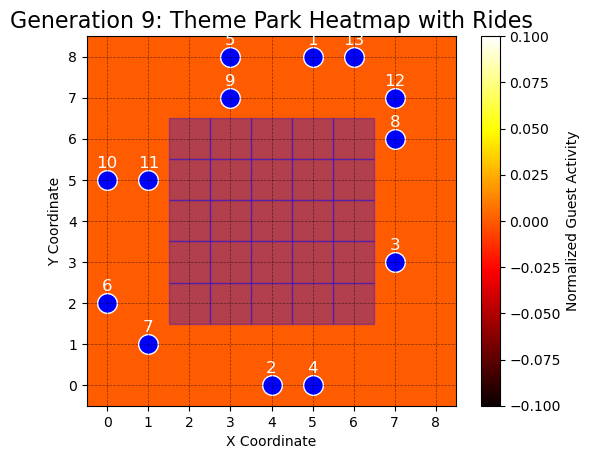

Selected rides by ranking: ['12', '3', '7', '1', '4', '8', '5', '2', '6', '9', '10', '13', '11']
Best ride positions: [(11, (7, 7)), (2, (7, 3)), (6, (1, 1)), (0, (5, 8)), (3, (5, 0)), (7, (7, 6)), (4, (3, 8)), (1, (4, 0)), (5, (0, 2)), (8, (3, 7)), (9, (0, 5)), (12, (6, 8)), (10, (1, 5))]
Step: 0


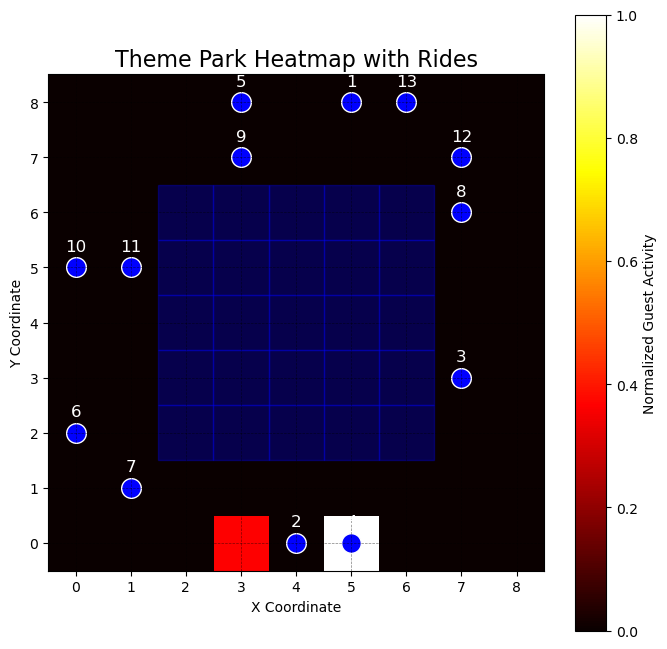

total guests: 116
Step: 10


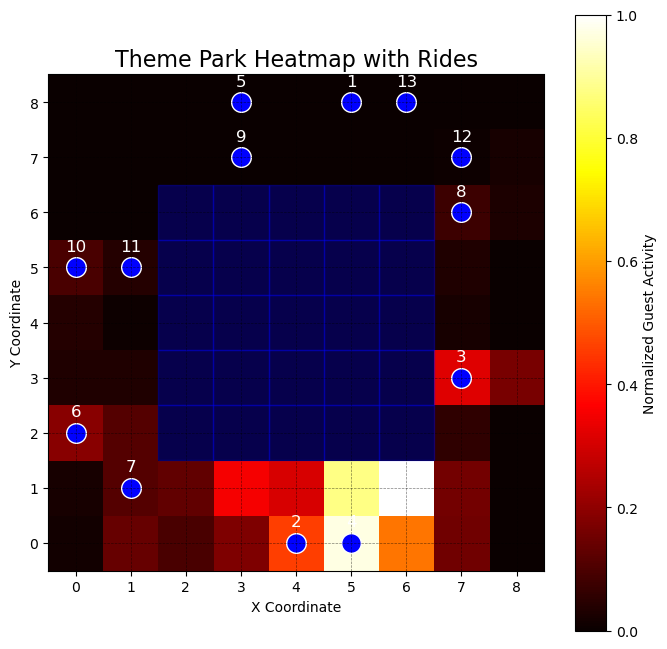

total guests: 978
Step: 20


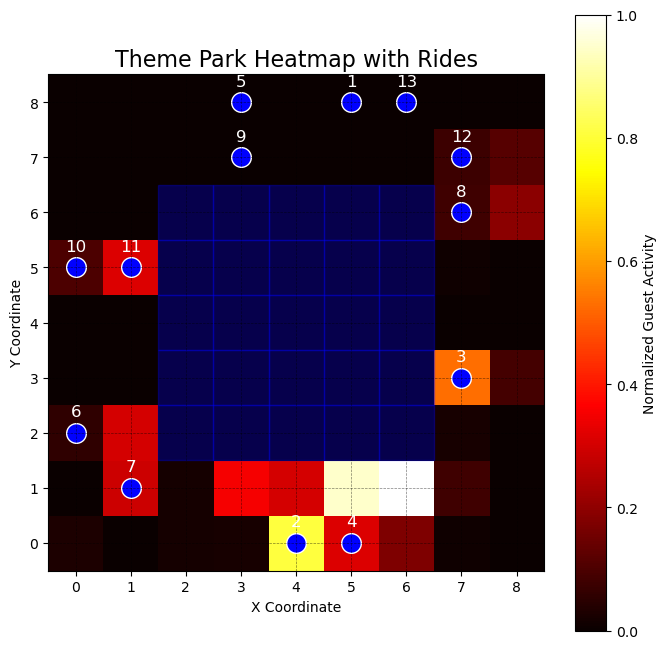

total guests: 1077
Step: 30


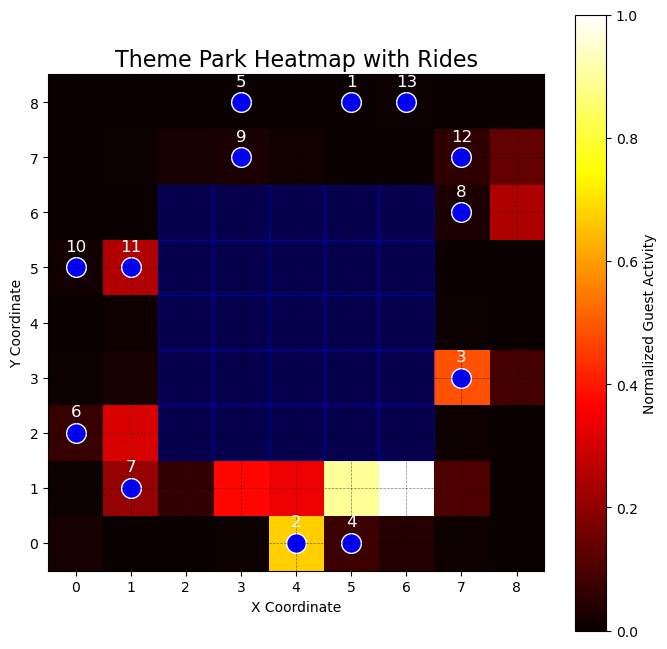

total guests: 1087
Step: 40


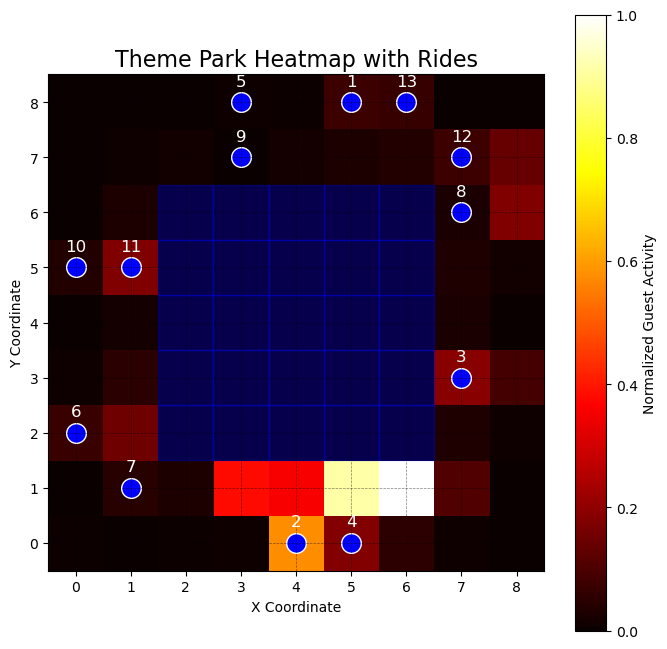

total guests: 1097
Step: 50


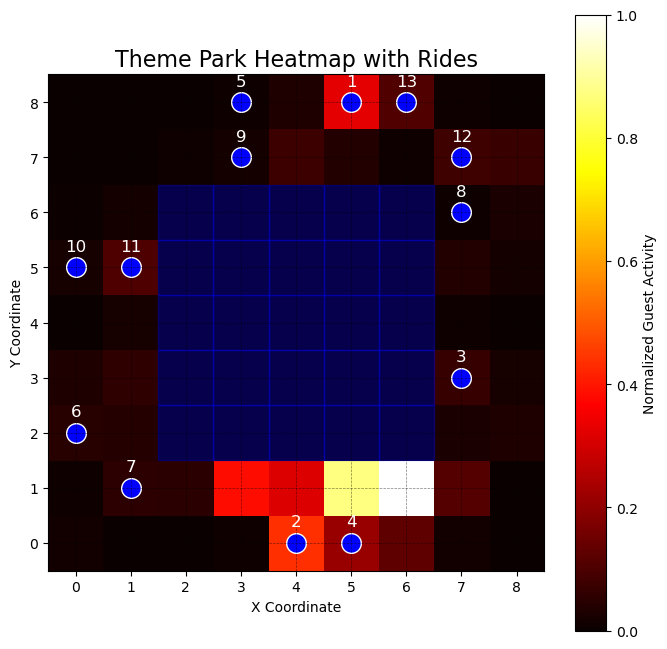

total guests: 1107
Step: 60


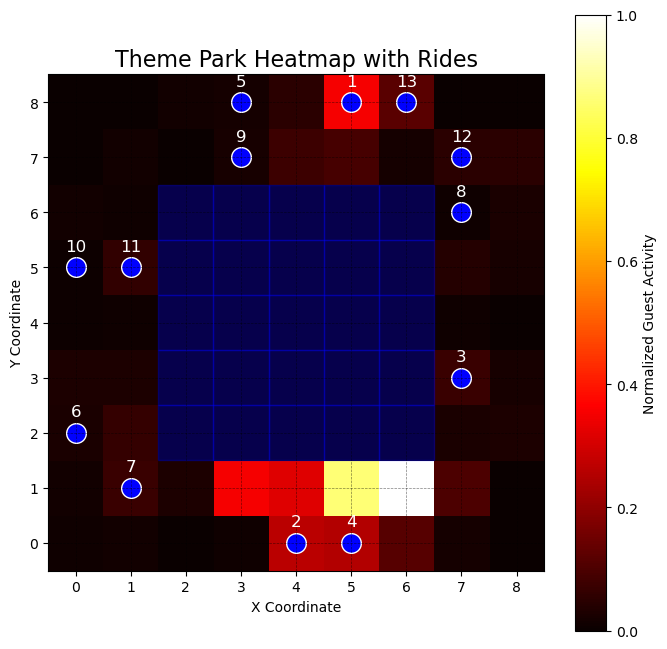

total guests: 1117
Step: 70


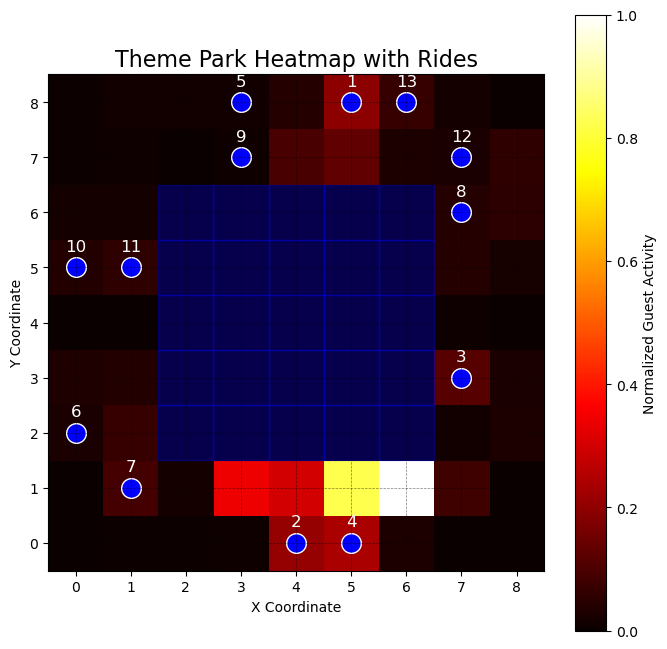

total guests: 1127
Step: 80


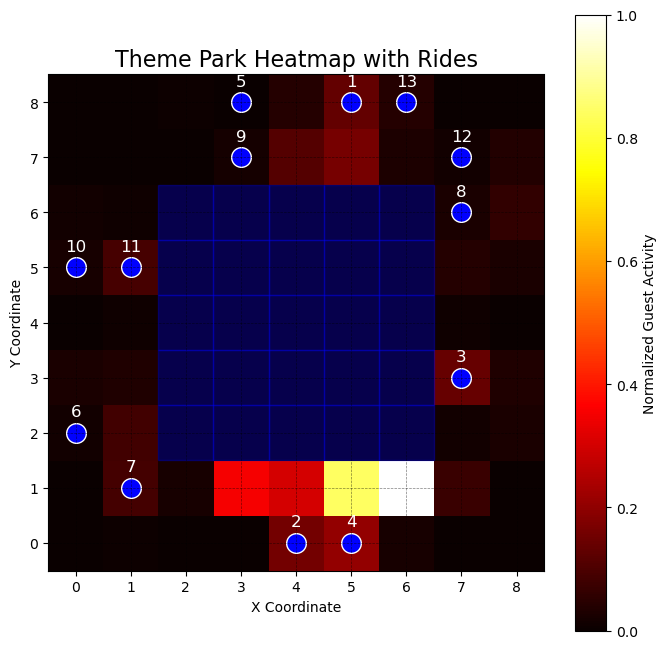

total guests: 1137
Step: 90


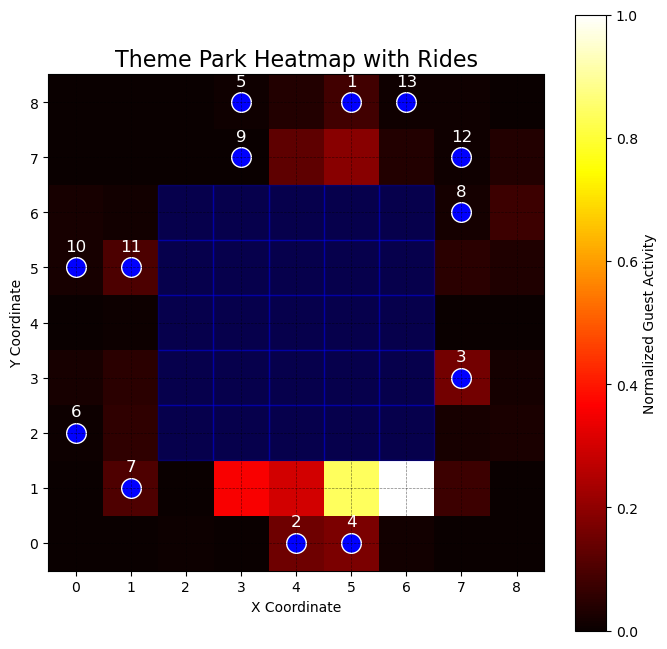

total guests: 1147
Step: 100


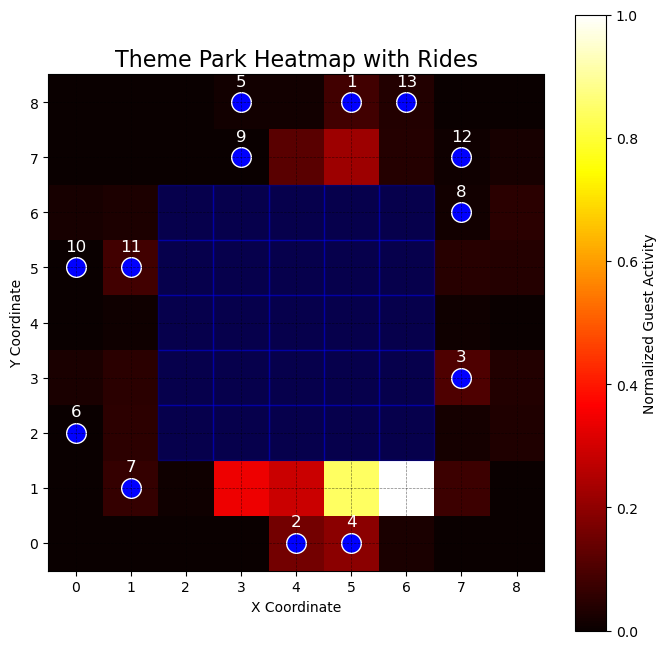

total guests: 1157
Step: 110


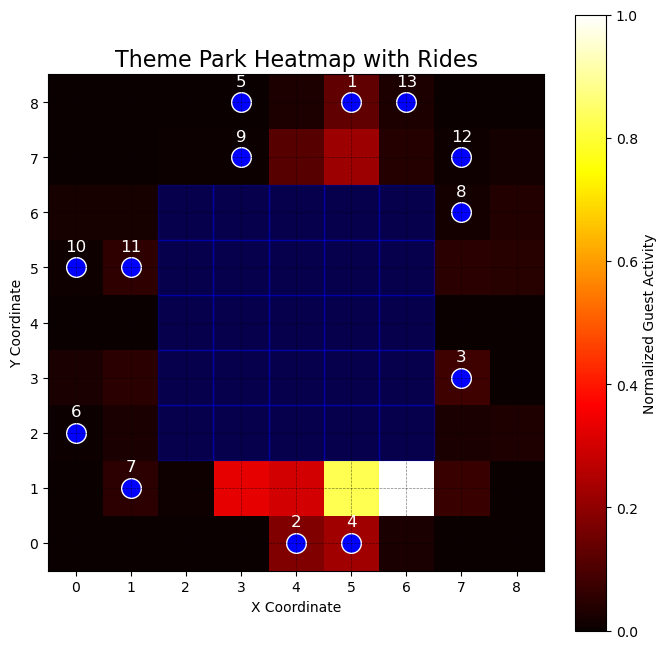

total guests: 1167
Step: 120


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
  File "c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\ipykernel\kernelapp.py", line 600, in sigint_handler
    raise KeyboardInterrupt
KeyboardInterrupt: 


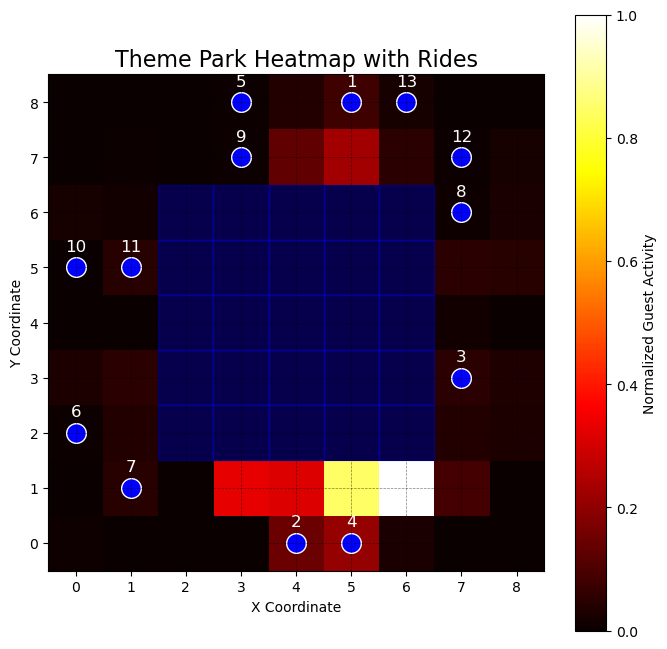

total guests: 1177
Step: 130


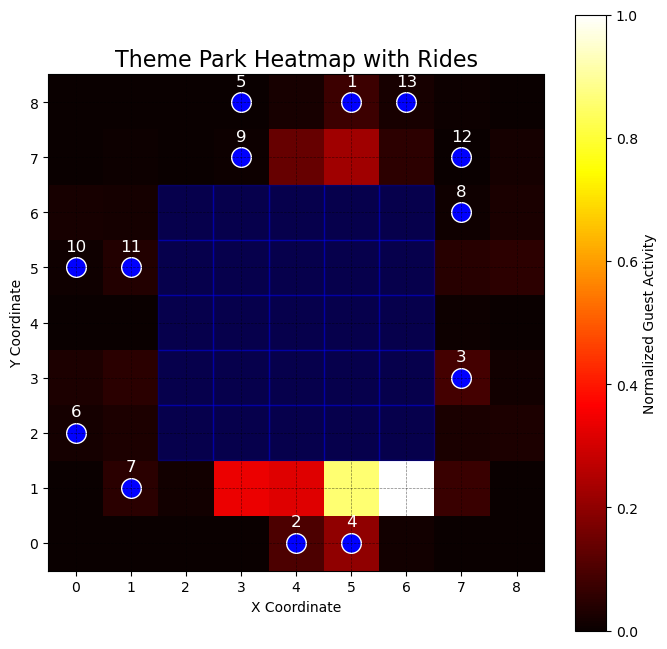

total guests: 1187
Step: 140


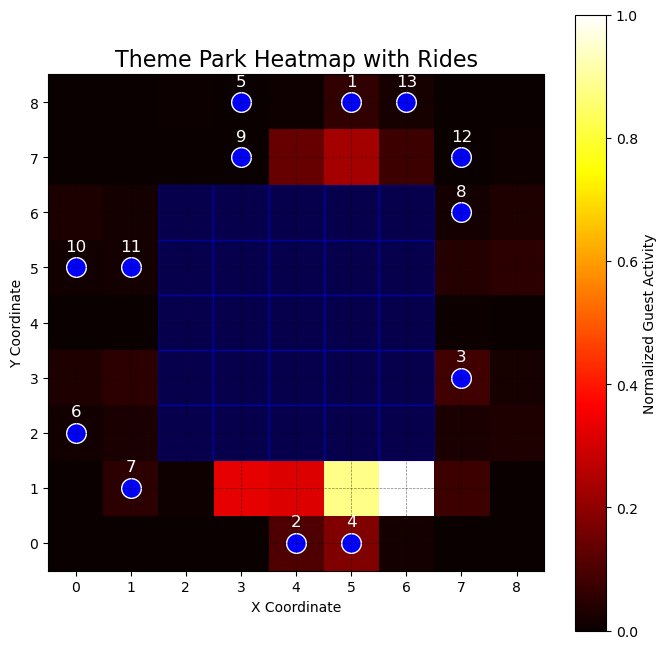

total guests: 1197
Step: 150


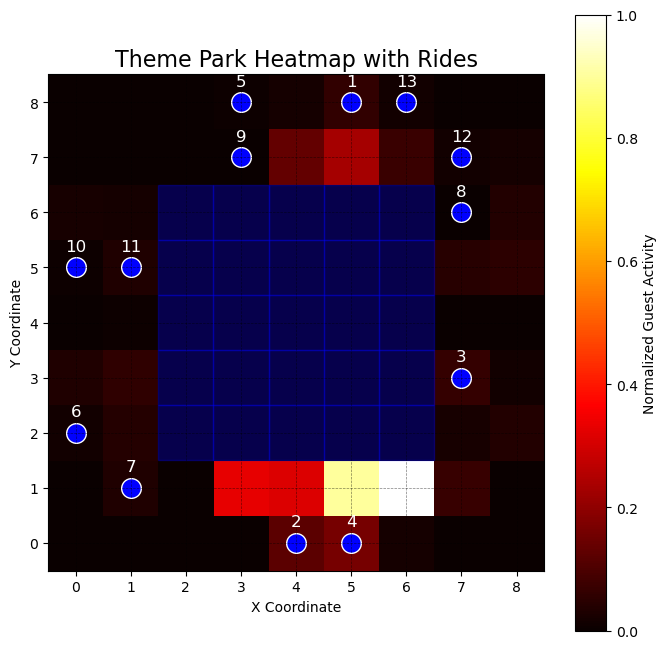

total guests: 1207
Step: 160


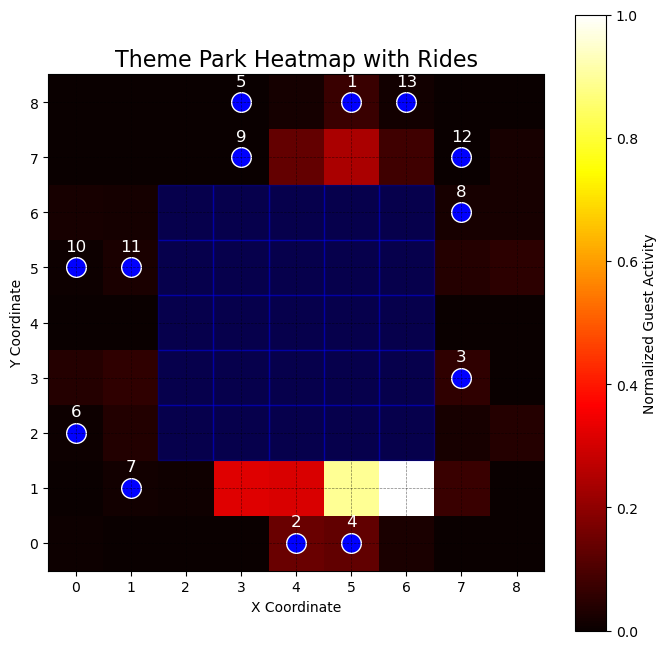

total guests: 1217
Step: 170


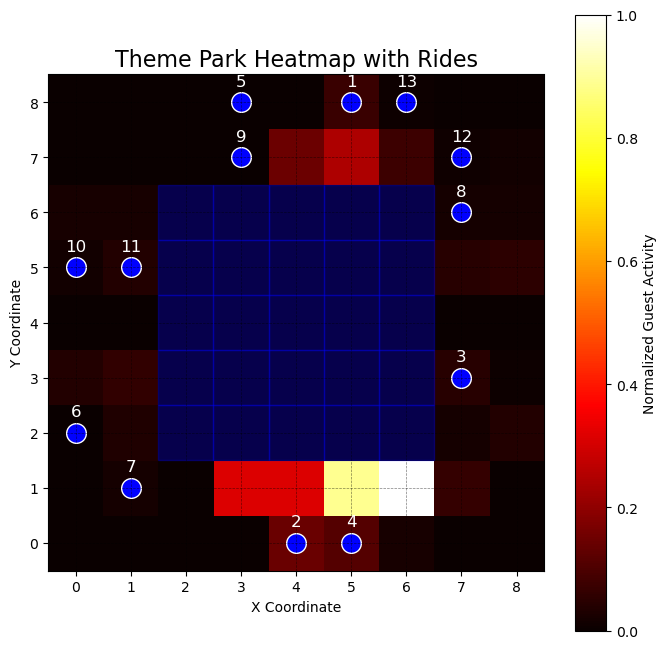

total guests: 1227
Step: 180


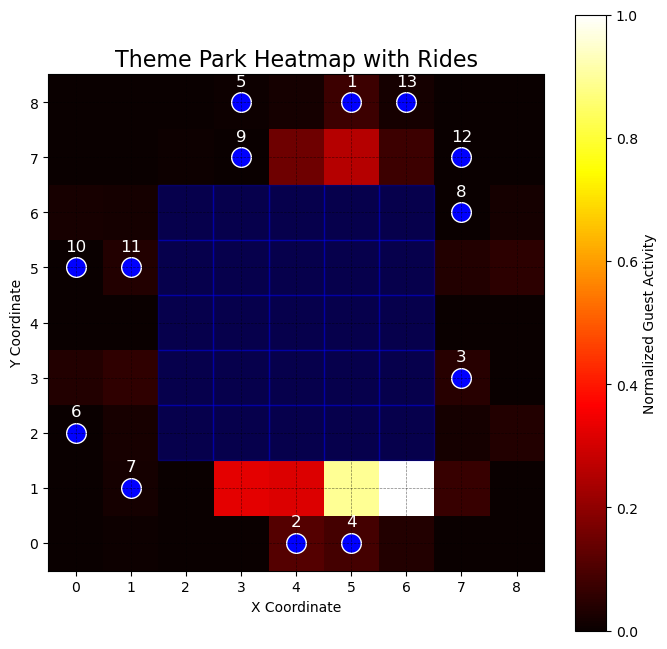

total guests: 1237
Step: 190


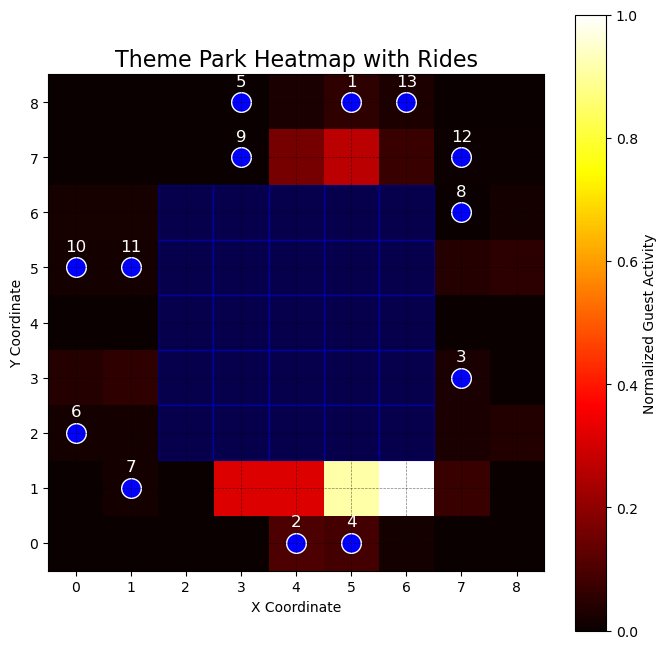

total guests: 1247
Step: 200


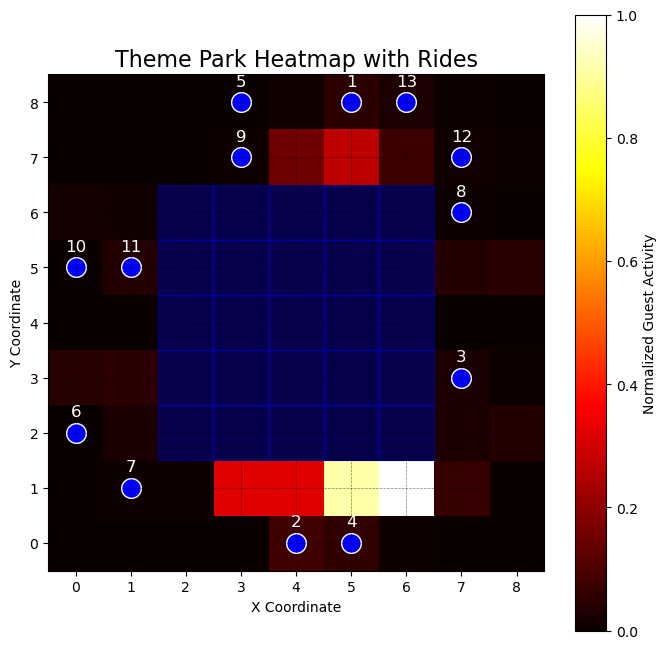

total guests: 1257
Step: 210


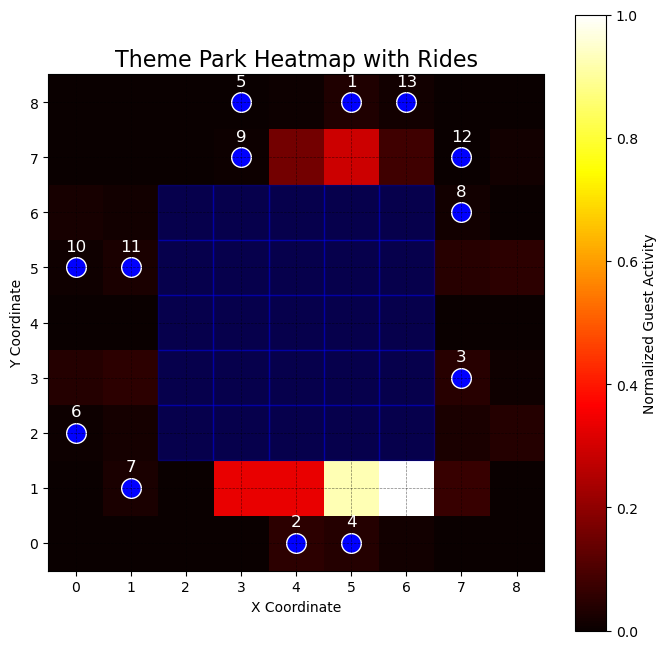

total guests: 1267
Step: 220


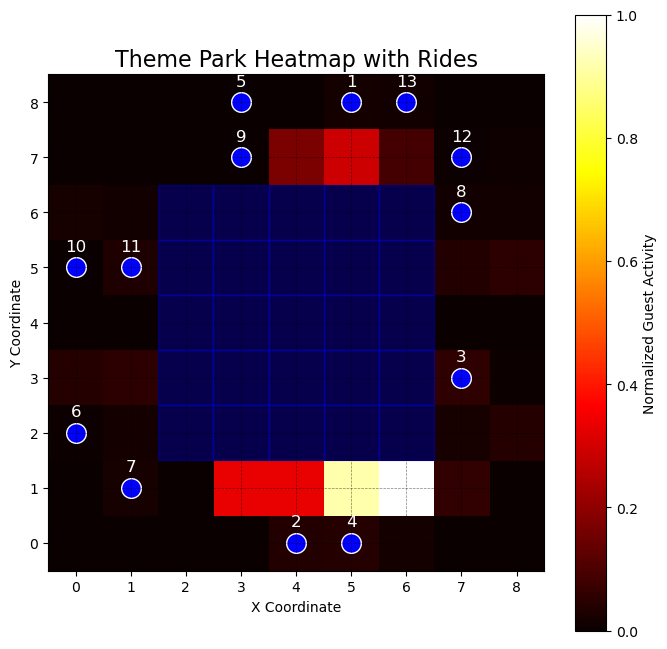

total guests: 1277
Step: 230


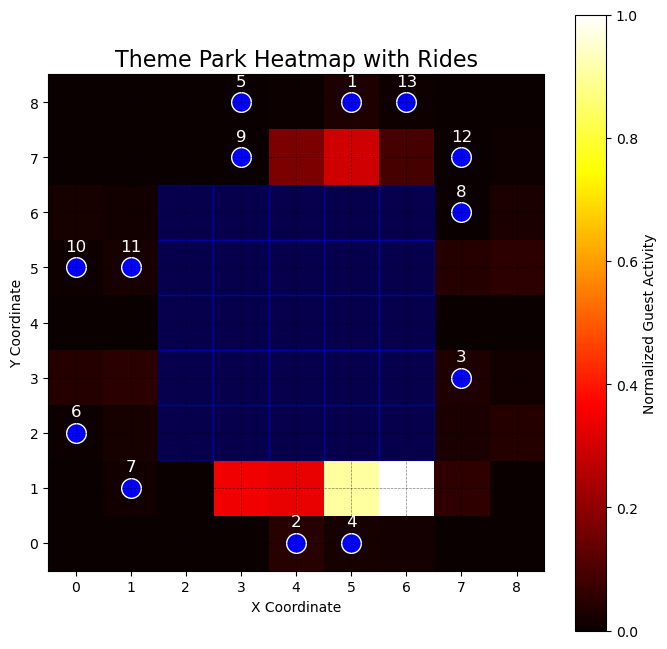

total guests: 1287
Step: 240


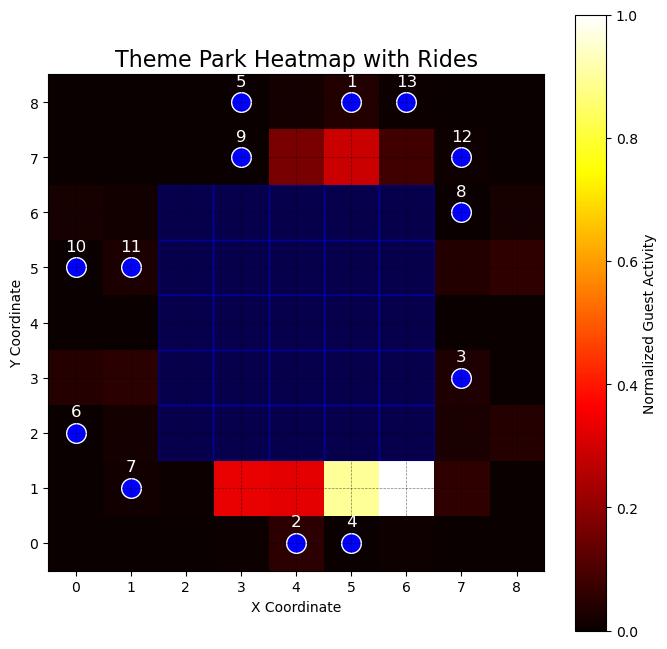

total guests: 1297
Step: 250


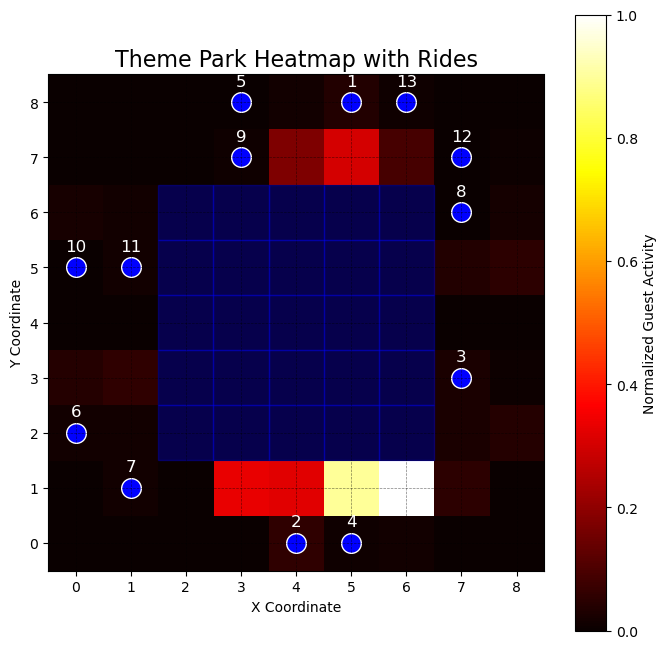

total guests: 1307
Step: 260


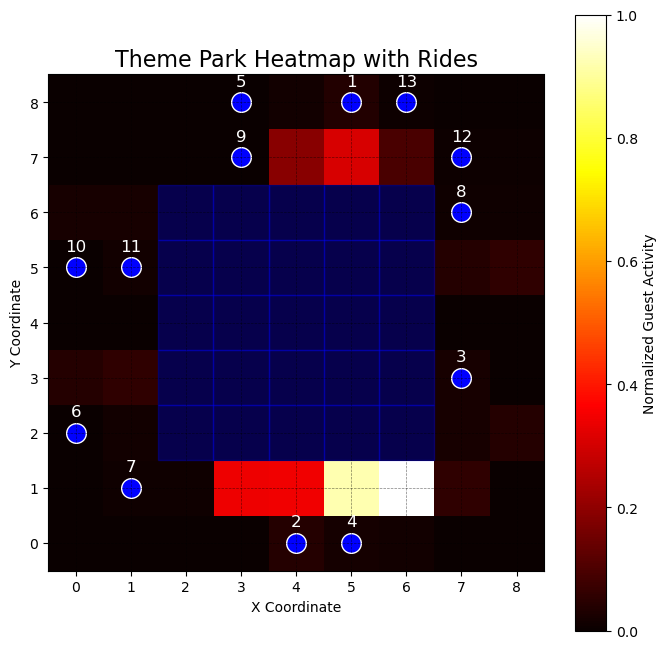

total guests: 1317
Step: 270


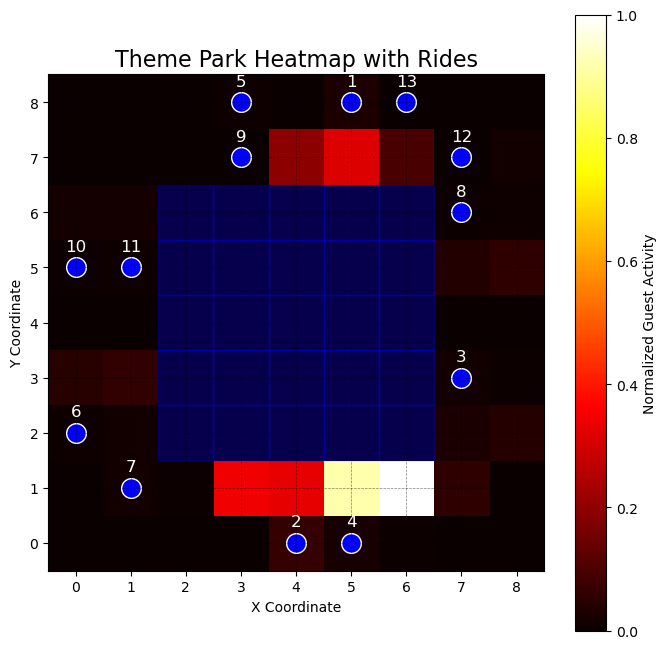

total guests: 1327
Step: 280


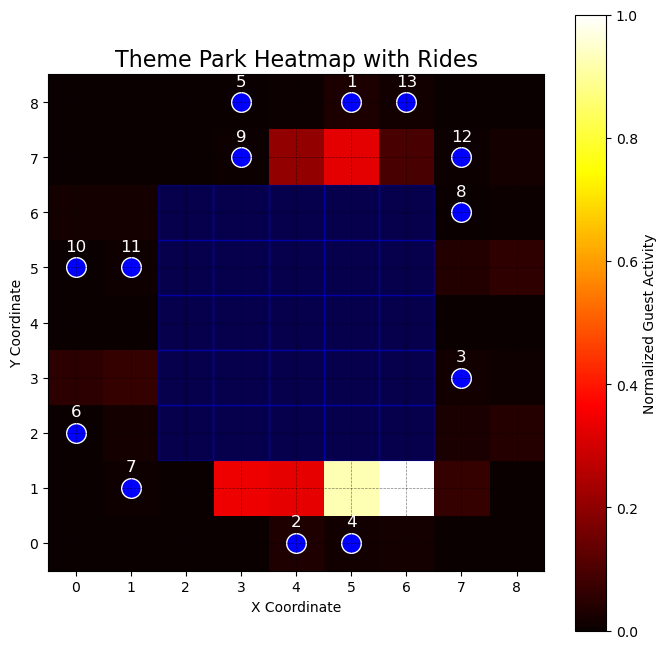

total guests: 1337
Step: 290


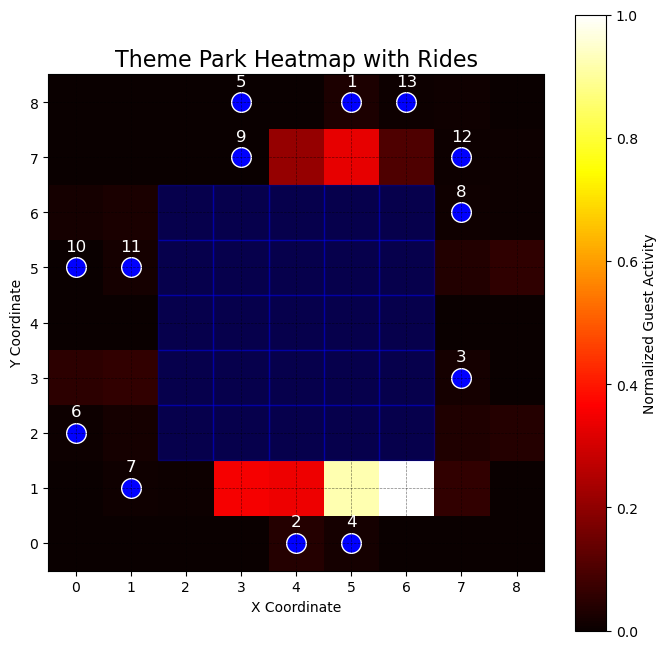

total guests: 1347
Step: 300


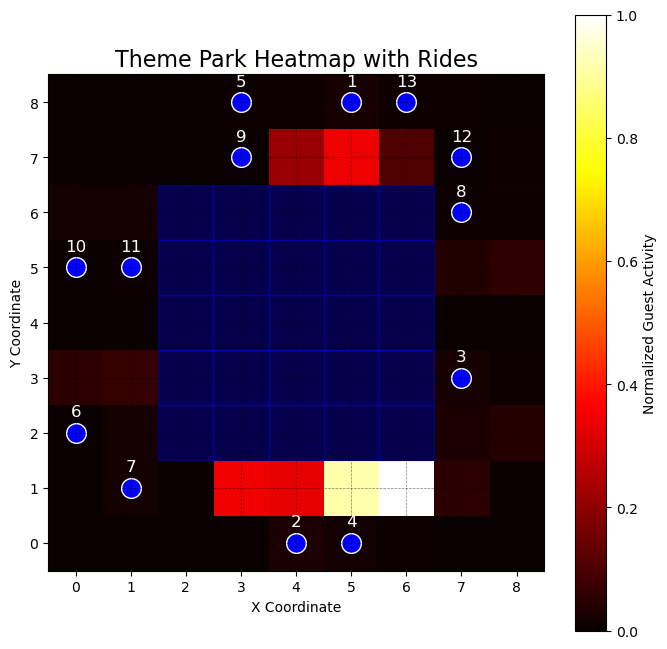

total guests: 1357
Step: 310


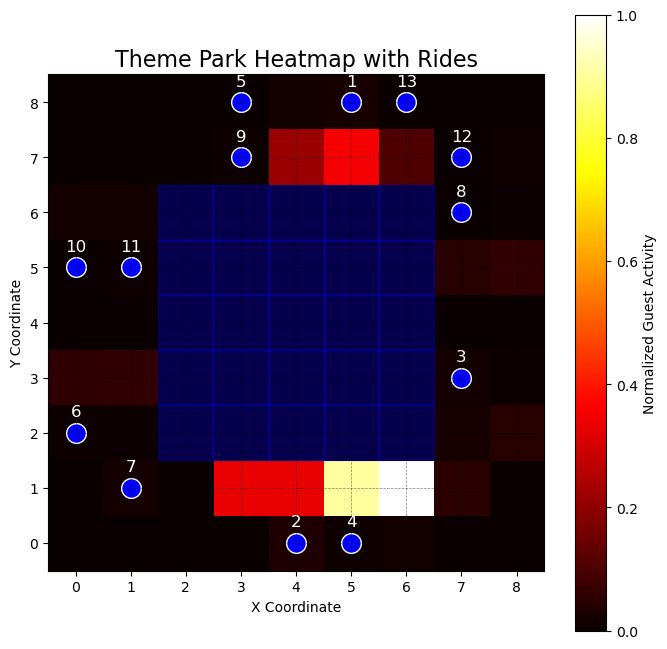

total guests: 1367
Step: 320


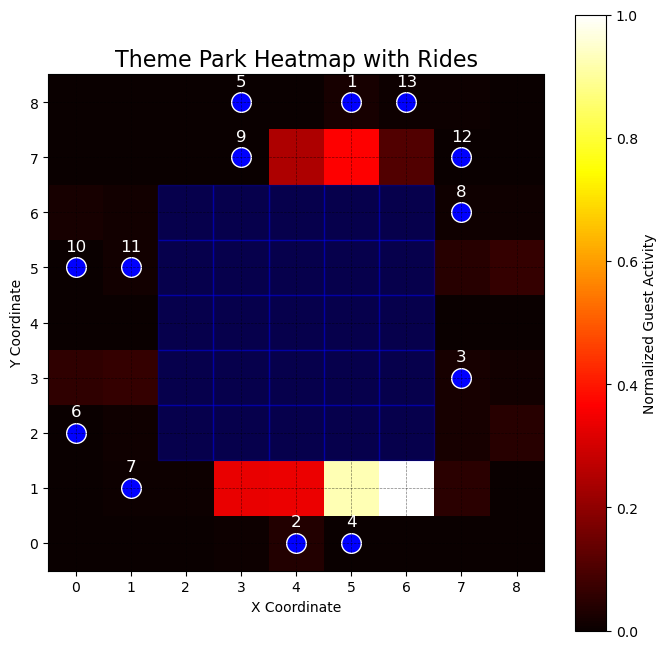

total guests: 1377
Step: 330


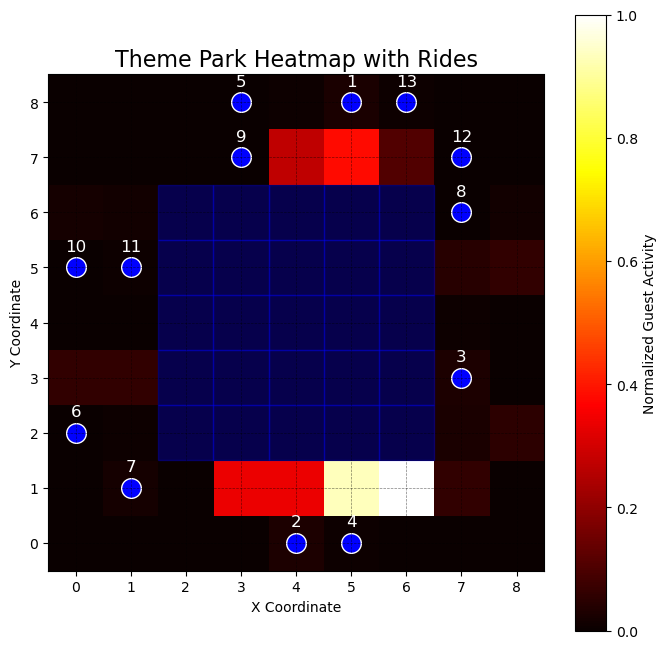

total guests: 1387
Step: 340


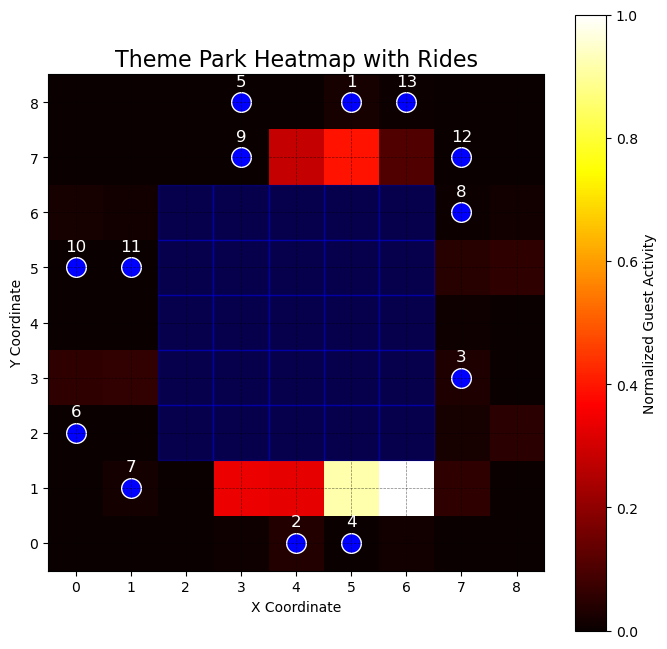

total guests: 1397
Step: 350


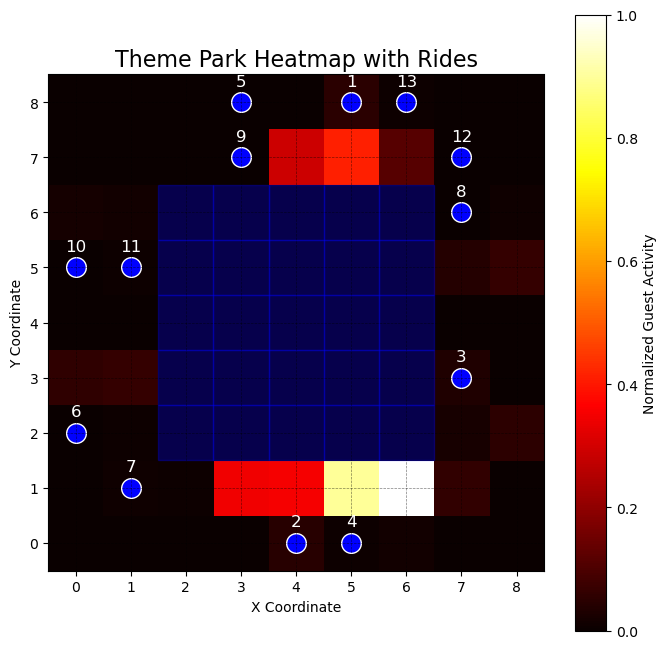

total guests: 1407
Step: 360


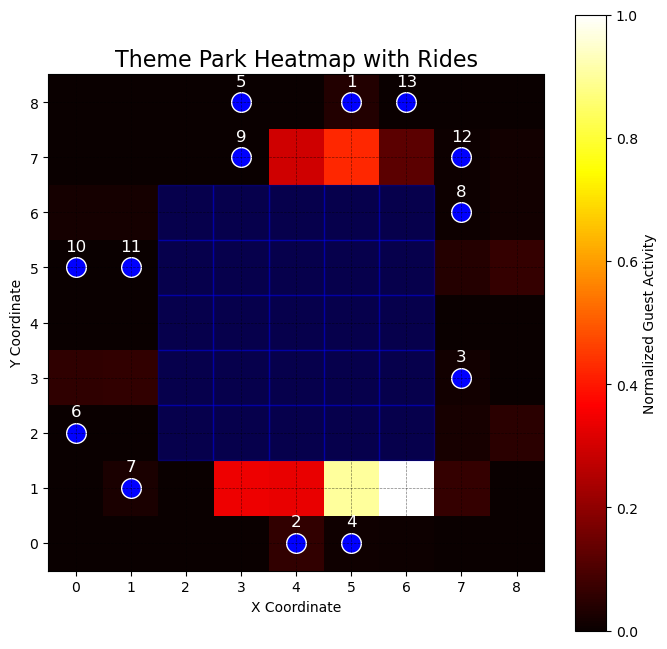

total guests: 1417
Step: 370


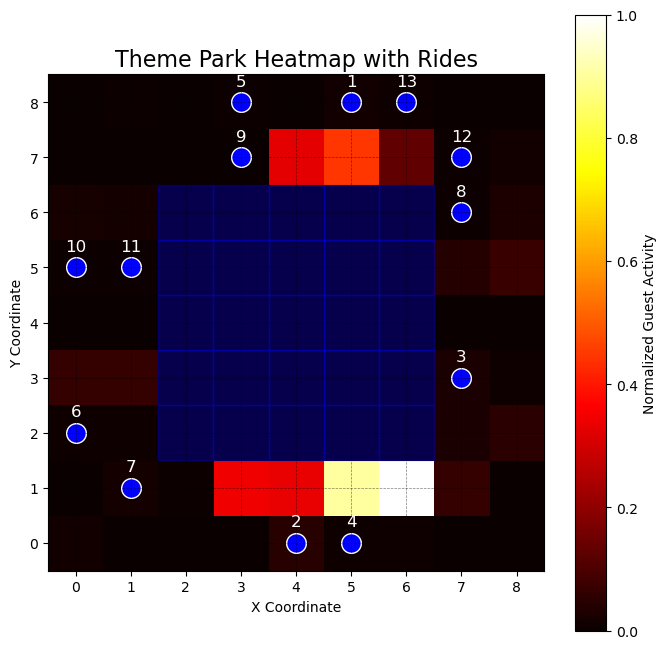

total guests: 1427
Step: 380


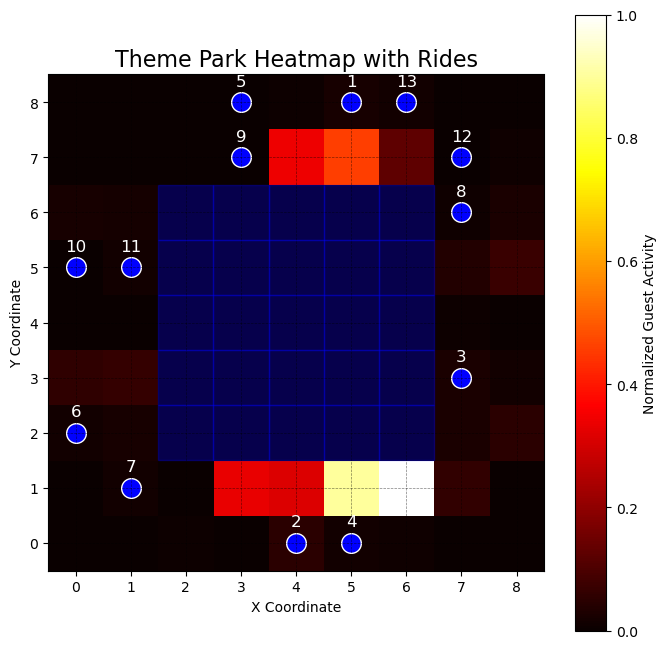

total guests: 1437
Step: 390


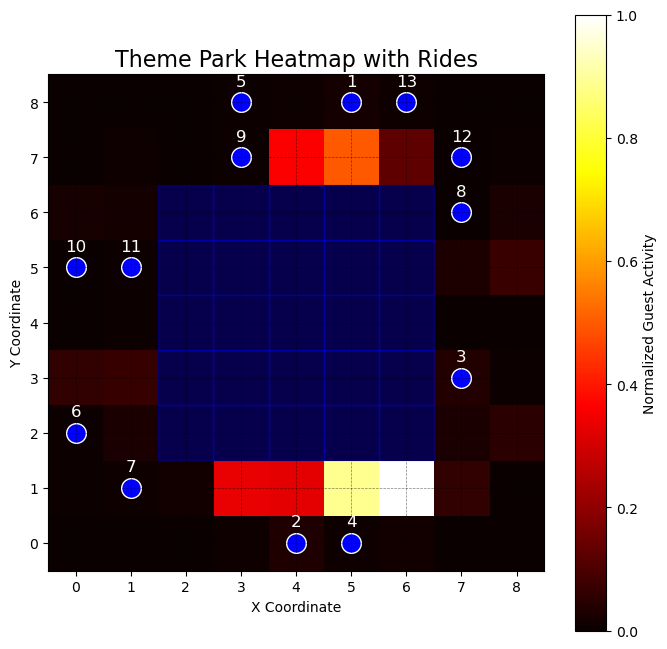

total guests: 1447
Step: 400


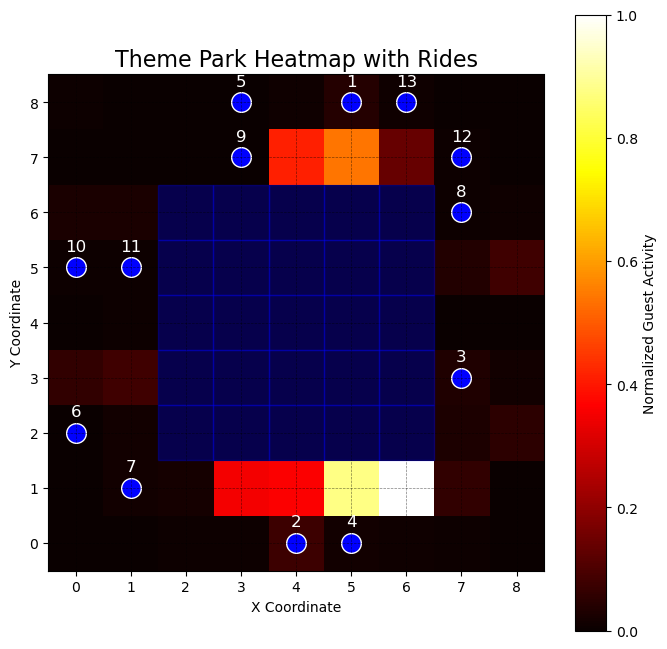

total guests: 1457
Step: 410


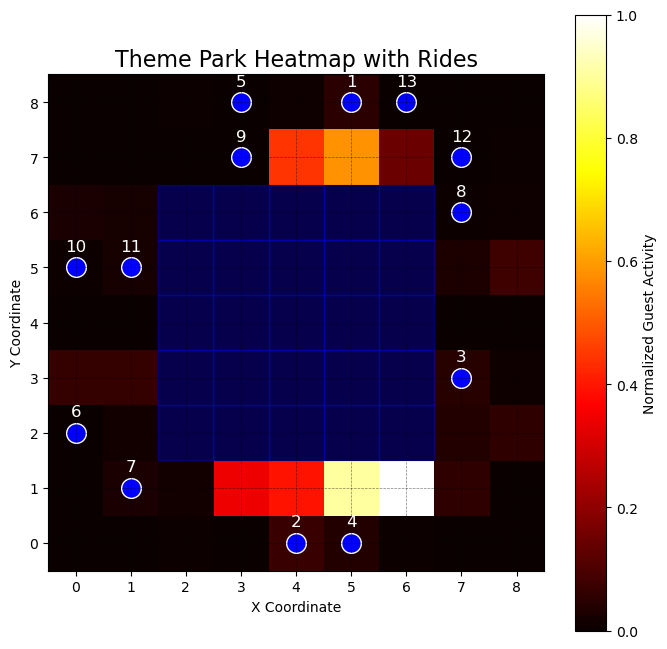

total guests: 1467
Step: 420


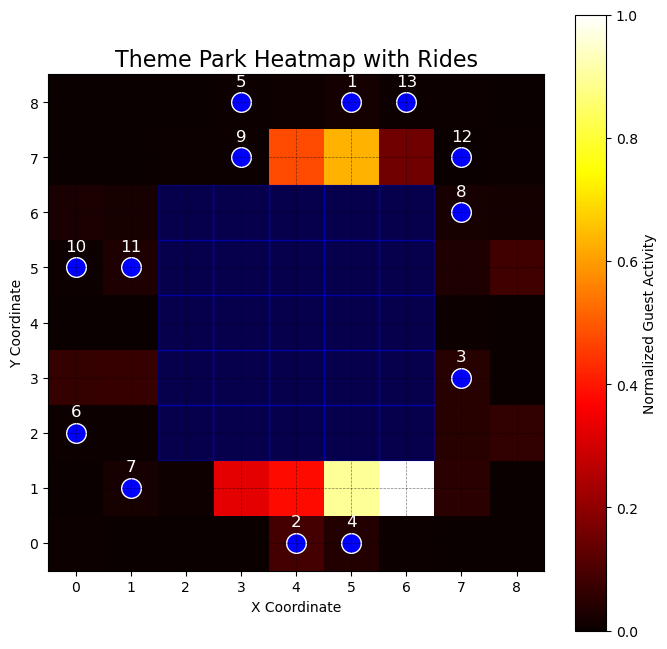

total guests: 1477
Step: 430


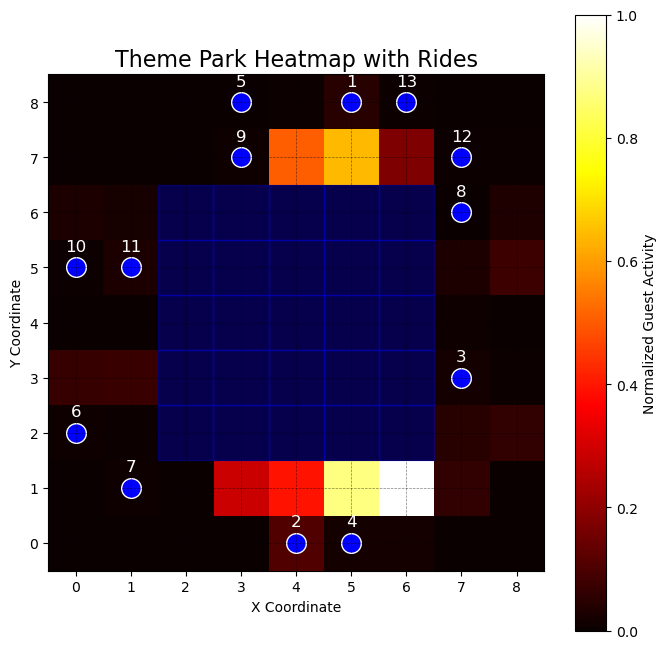

total guests: 1487
Step: 440


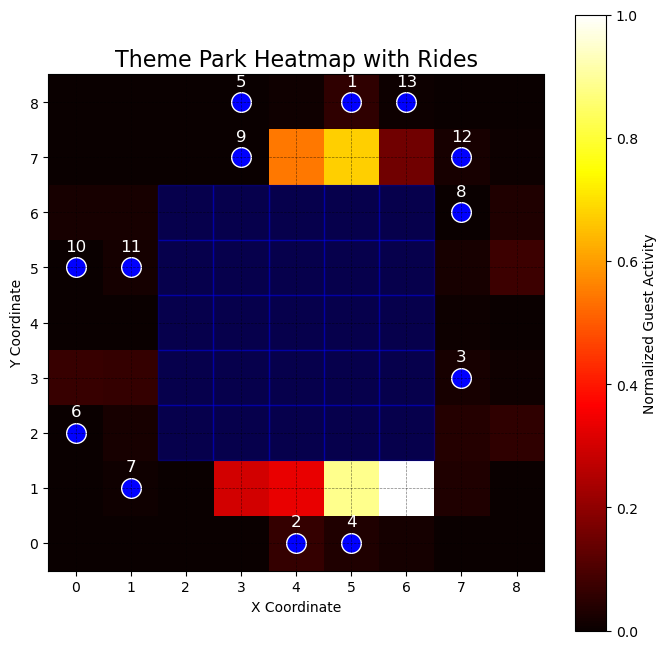

total guests: 1497
Step: 450


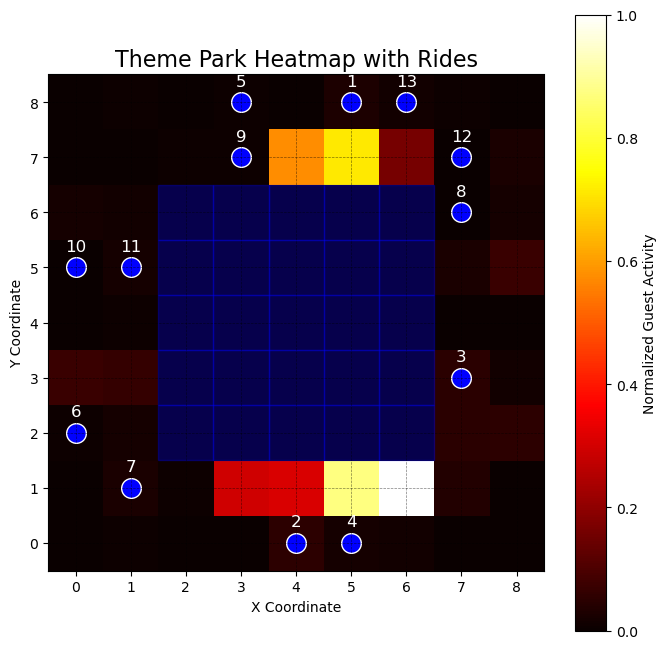

total guests: 1507
Step: 460


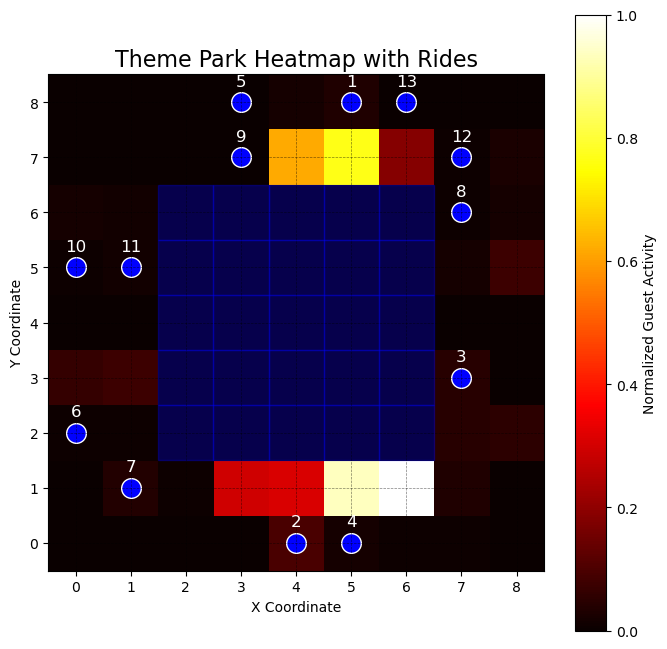

total guests: 1517
Step: 470


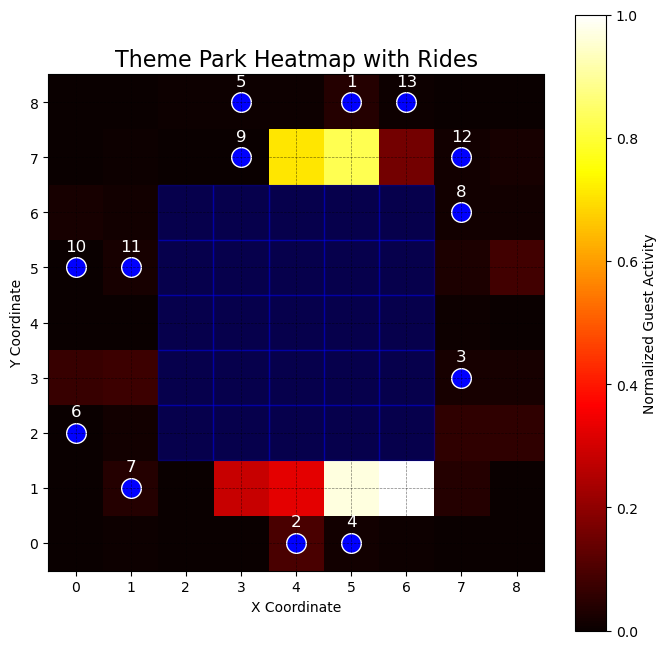

total guests: 1527
Step: 480


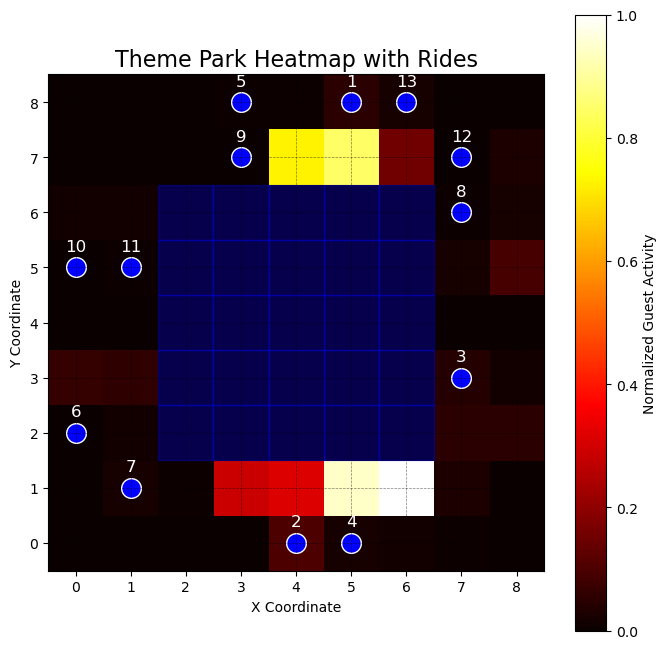

total guests: 1537
Step: 490


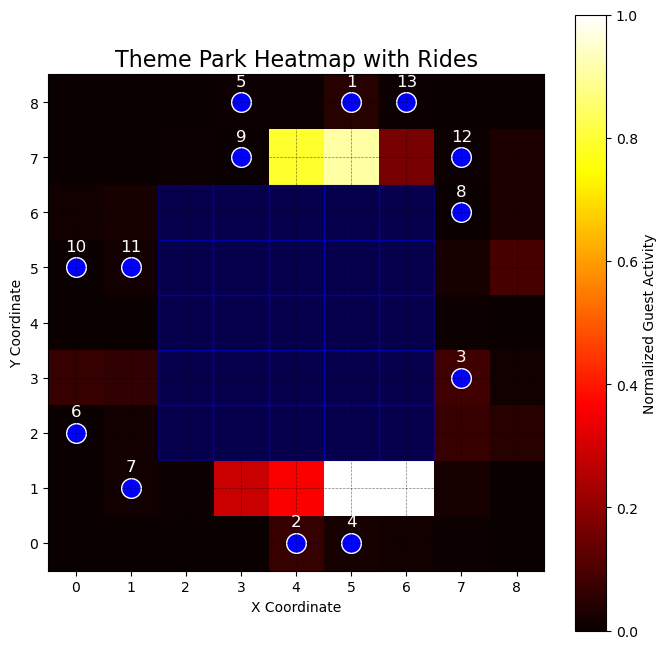

total guests: 1547
Step: 500


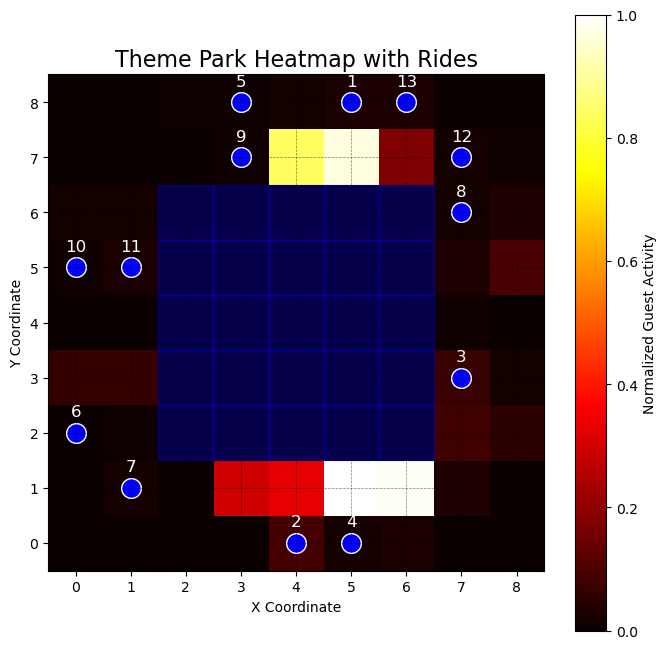

total guests: 1557
Step: 510


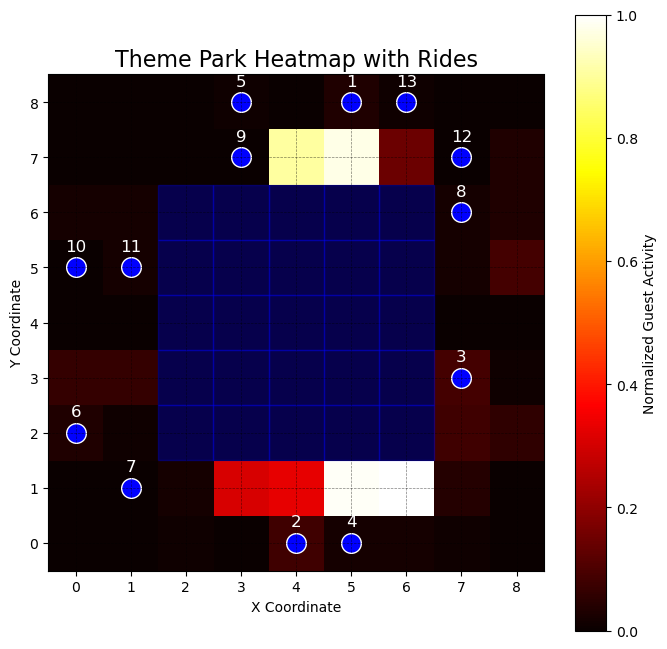

total guests: 1567
Step: 520


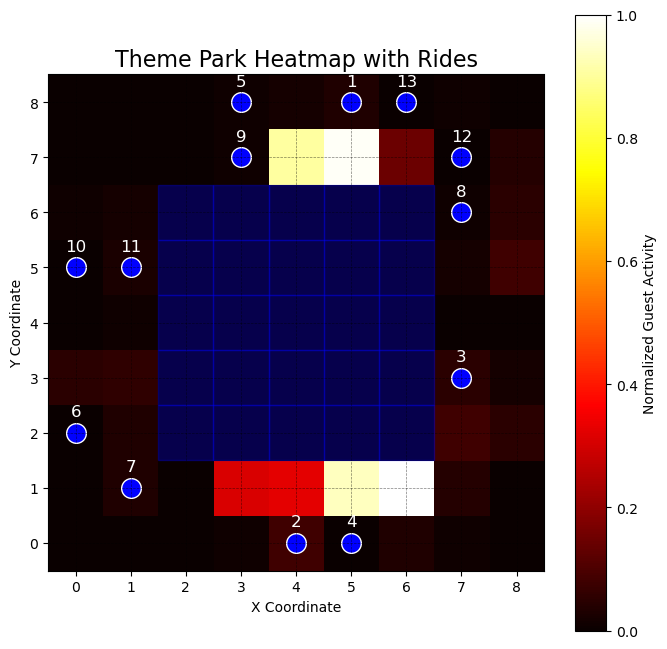

total guests: 1577
Step: 530


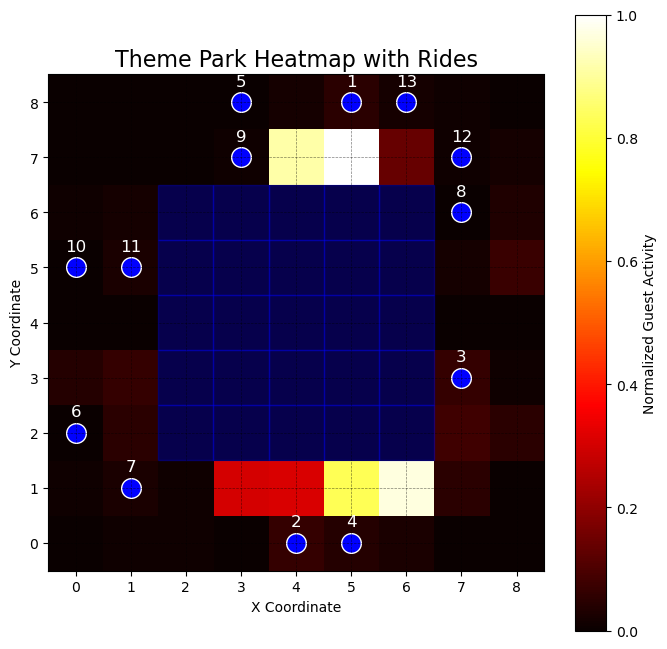

total guests: 1587


In [27]:
ringmodel = ThemeParkGridModel(9,9,(2,2),(6,6))

start_simulation_run(ringmodel, tivoli_attr_ranking, 13)
